In [1]:
# Input info
#outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_A2_black/annotation_clones/fate_correlation/scrap/minC5_corr.Kendall.b/"
#se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
se_cells_meta_f = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04/data/clone_var_init/variants.prefilterMerge_impute_knnRes.30/aggregate/annotation/se_cells_meta_labels.tsv"
outdir = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04/data/clone_var_init/variants.prefilterMerge_impute_knnRes.30/aggregate/annotation/fate_corr/minC5_corr.Kendall.b_group_inputOnly/"


use_input = True
min_cell = 5
input_col = "Input"
corr_method = "kendall_b"
to_rm_zero = False
pseudocount = 1

to_group = True

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import colorcet as cc
%matplotlib inline
import numpy as np
from mplh.fig_utils import helper_save as hs

fig_utils from mplh


In [3]:
sns.set(font_scale = 1.3)


In [4]:
def keep_top_clones(df, n_top=None, min_cell=0):
    df = df.sort_values("ncells",ascending=False)
    if n_top is not None:
        df = df[:n_top]
    return df.loc[df["ncells"]>min_cell]

In [5]:
def get_clone_count(x, clone_counts):
    curr = clone_counts[clone_counts["name"]==x.name]
    return curr.set_index("nuclear_clusters")["ncells"]


In [6]:
se_cells_meta = pd.read_csv(se_cells_meta_f, sep='\t')
if "cluster_labels" in se_cells_meta.columns:
    se_cells_meta = se_cells_meta.rename({"cluster_labels":"nuclear_clusters"}, axis=1)
else:
    se_cells_meta = se_cells_meta.rename({"seurat_clusters":"nuclear_clusters"}, axis=1)
se_cells_meta["nuclear_clusters"] = se_cells_meta["nuclear_clusters"].astype(object).astype(str)



### Remove None before normalizing
if use_input:
    se_cells_meta = se_cells_meta[se_cells_meta["orig.ident"] == input_col]
se_cells_meta = se_cells_meta[se_cells_meta["donor"] != "None"]

if to_group:
    se_cells_meta["nuclear_clusters"] = se_cells_meta["nuclear_clusters"].apply(lambda x: ''.join(i for i in x if not i.isdigit()))
    
se_cells_meta

Unnamed: 0 orig.ident  nCount_ATAC  \
7347   CHIP_a1_Input_AAACGAATCCCAGTAA-1      Input         2234   
7348   CHIP_a1_Input_AAACGAATCGTGAACT-1      Input         6325   
7349   CHIP_a1_Input_AAACTCGAGGTACACG-1      Input         5299   
7350   CHIP_a1_Input_AAACTCGCAAGACACG-1      Input         3830   
7351   CHIP_a1_Input_AAACTCGCACTGTTAG-1      Input         1340   
...                                 ...        ...          ...   
18314  CHIP_b2_Input_TTTGTGTCATGGCCTG-1      Input         2009   
18315  CHIP_b2_Input_TTTGTGTGTGGAAAGA-1      Input         6841   
18316  CHIP_b2_Input_TTTGTGTGTGGACAGT-1      Input         1877   
18317  CHIP_b2_Input_TTTGTGTTCAGTACAC-1      Input         3000   
18318  CHIP_b2_Input_TTTGTGTTCTATAGGC-1      Input         8494   

       nFeature_ATAC    total  duplicate  chimeric  unmapped  lowmapq  \
7347            2234  30056.0       2764       124        63      832   
7348            6325  66340.0      10716       362       165     2305   
7349            5299  49202.0       9164       265       116     1810   
7350            3830  45793.0       6391       211       100     1554   
7351            1340  62076.0       2215        76       153     1953   
...              ...      ...        ...       ...       ...      ...   
18314           2009   8747.0       1284        52        37      278   
18315           6841  35511.0       7946       148       118     1467   
18316           1877  14217.0       2190        42        40      420   
18317           3000  15165.0       2707        67        52      475   
18318           8494  48687.0      14365       242       206     2591   

       mitochondrial  ...  seurat_clusters nCount_ATAC_log2  nCount_RNA  \
7347           22385  ...                4        11.126059        2468   
7348           39978  ...                6        12.627078        8382   
7349           27219  ...                0        12.371777        5878   
7350           30248  ...                2        11.903505        4241   
7351           55119  ...               14        10.389094        1830   
...              ...  ...              ...              ...         ...   
18314           4416  ...               10        10.972980        1969   
18315          14501  ...                7        12.740202        8019   
18316           8229  ...                1        10.874981        1912   
18317           7195  ...                1        11.551228        3143   
18318           7487  ...               11        13.052398       13695   

       nFeature_RNA                         Row.names          name      run  \
7347           2156  CHIP_a1_Input_AAACGAATCCCAGTAA-1  CHIP_a1_0_25  CHIP_a1   
7348           5515  CHIP_a1_Input_AAACGAATCGTGAACT-1   CHIP_a1_0_2  CHIP_a1   
7349           4291  CHIP_a1_Input_AAACTCGAGGTACACG-1   CHIP_a1_0_4  CHIP_a1   
7350           3334  CHIP_a1_Input_AAACTCGCAAGACACG-1   CHIP_a1_0_0  CHIP_a1   
7351           1554  CHIP_a1_Input_AAACTCGCACTGTTAG-1  CHIP_a1_1_27  CHIP_a1   
...             ...                               ...           ...      ...   
18314          1714  CHIP_b2_Input_TTTGTGTCATGGCCTG-1  CHIP_b2_1_12  CHIP_b2   
18315          5370  CHIP_b2_Input_TTTGTGTGTGGAAAGA-1  CHIP_b2_1_15  CHIP_b2   
18316          1659  CHIP_b2_Input_TTTGTGTGTGGACAGT-1   CHIP_b2_0_8  CHIP_b2   
18317          2556  CHIP_b2_Input_TTTGTGTTCAGTACAC-1  CHIP_b2_1_23  CHIP_b2   
18318          7620  CHIP_b2_Input_TTTGTGTTCTATAGGC-1   CHIP_b2_0_7  CHIP_b2   

           donor  condition  nuclear_clusters  
7347   CHIP_a1_0      Input       Granulocyte  
7348   CHIP_a1_0      Input              MkP   
7349   CHIP_a1_0      Input         Monocyte   
7350   CHIP_a1_0      Input       Neutrophil   
7351   CHIP_a1_1      Input          Unknown   
...          ...        ...               ...  
18314  CHIP_b2_1      Input             HPSC   
18315  CHIP_b2_1      Input             HPSC   
18316  CHIP_b2_0      Input             HPSC   
18317

In [7]:
palette = sns.color_palette(cc.glasbey, n_colors=len(se_cells_meta["nuclear_clusters"].unique()))
hue_order = se_cells_meta.groupby("nuclear_clusters").size().sort_values()[::-1].index
color_d = {key:val for key, val in zip(hue_order, palette)}



In [8]:
clone_counts = (se_cells_meta.groupby(["name", "nuclear_clusters","donor"]).size()+pseudocount).reset_index().rename({0:"ncells"}, axis=1)
clone_counts = clone_counts[~(clone_counts["name"]=="None")]
clone_counts_combined = clone_counts.groupby(["name", "donor"]).sum()["ncells"].reset_index().sort_values("ncells", ascending=False).set_index("name")

clone_counts_df = pd.concat((clone_counts_combined, clone_counts_combined.apply(get_clone_count, axis=1, args=(clone_counts,))),axis=1).fillna(0)

def convert_log2(df):
    log2_df = df.copy()
    log2_df[hue_order] = np.log2(1+log2_df[hue_order])
    return log2_df
     


## Fate correlation

In [9]:
## Get top, middle, and bottom 2 correlations - Conditions combined

def repr_vals(x, n=2):
    """Get top, middle, and bottom 2 correlations - Conditions combined
    
    Assumes values are sorted
    """
    x_len = len(x)
    top = x[:min(len(x),n)]
    bot = []
    if x_len >= n*2:
        bot = x[::-1][:n]
        mid = []
        if x_len >= n*3:
            mid = x[int((len(x)/2)-(n/2)): int((len(x)/2)+(n/2))]
    return np.concatenate((top, bot, mid))


def top_vals(x, n=5):
    """Assumes values are sorted"""
    x_len = len(x)
    return x[:min(len(x),n)]


def repr_df(corr_vals, all_corr_df):
    repr_corr = all_corr_df.isin(corr_vals)
    repr_corr_inds = repr_corr[repr_corr > 0].stack().index.tolist()
    repr_corr_inds_df = pd.DataFrame(repr_corr_inds)
    repr_corr_inds_df["nm"] = repr_corr_inds_df.apply(lambda x: "-MERGE-".join(np.sort(x.values)), axis=1)

    repr_corr_inds_df = repr_corr_inds_df.loc[~(repr_corr_inds_df.duplicated(subset=["nm"]))].drop("nm", axis=1)
    repr_corr_inds_df["spearman corr"] = repr_corr_inds_df.apply(lambda x: all_corr_df.loc[x[0], x[1]], axis=1)
    repr_corr_inds_df = repr_corr_inds_df.sort_values("spearman corr")[::-1]
    return repr_corr_inds_df

def corr_df_flatten(df):
    vals = np.sort(list(set(df.values.flatten())))[::-1]
    return vals[vals!=1] # remove the diagonals

def plot_repr_corr(df, all_corr_df, label, top=False, out_f=None):
    vals = corr_df_flatten(all_corr_df)
    if top:
        corr_vals = top_vals(vals, n=5) #top, middle, and bottom n correlations
    else:
        corr_vals = repr_vals(vals, n=2) #top, middle, and bottom n correlations
    repr_corr_inds_df = repr_df(corr_vals, all_corr_df)
    corr_cat_df = []
    for ind, val in repr_corr_inds_df.iterrows():
        curr = df.loc[:,[val[0], val[1]]].copy()
        curr["comp"] = f'{"__".join(curr.columns)} ({corr_method} r={val["spearman corr"]:.3f})'
        curr = curr.rename({val:str(ind) for ind, val in enumerate([val[0], val[1]])}, axis=1)
        corr_cat_df.append(curr)
        
    g = sns.lmplot(data=pd.concat(corr_cat_df,axis=0), x="0", y="1", hue="comp", height=12, scatter=False);
    plt.ylabel(label)
    plt.xlabel(label)
    plt.suptitle("Top, middle, and bottom 2 paired correlations")
    if top:
        plt.suptitle(f"Top 5 paired correlations")
    if out_f is not None:
        hs(out_f, to_pdf=True)
    return corr_cat_df

In [10]:
from scipy.stats import kendalltau, spearmanr

def kendalltau_b(x,y, met='corr'):
    if met == 'corr':
        return kendalltau(x, y, variant='b')[0]
    elif met == "pval":
        return kendalltau(x, y, variant='b')[1]
    

    
def filt_zero(x, y):
    if to_rm_zero:
        keep_inds = np.where((x!=0) & (y!=0))
        return x[keep_inds], y[keep_inds]
    return (x,y)

def get_corr(df, corr_method):
    df = df.copy().drop(["ncells", "donor"],axis=1, errors='ignore')
    if corr_method == "spearman":
        corr_df = df.corr(method=lambda x, y: spearmanr(*filt_zero(x, y))[0]).fillna(0) 
        pval_df = df.corr(method=lambda x, y: spearmanr(*filt_zero(x, y))[1]) - (np.eye(len(corr_df)))
    elif corr_method == "kendall_b":
        corr_df = df.corr(method=lambda x, y: kendalltau(*filt_zero(x, y), variant='b')[0]).fillna(0)
        pval_df = df.corr(method=lambda x, y: kendalltau(*filt_zero(x, y), variant='b')[1]) - (np.eye(len(corr_df)))
        
    return corr_df, pval_df



### a) Donors in sequenced run combined (min_cell)

In [11]:
# #if rm_zero:
# def filt_zero(df, rm_zero):
#     if rm_zero:
#         df.loc[df.drop(["donor", "ncells"], axis=1)]
#         return 
        
#     return df

# def get_corr_np(corr_df):
#     corr_np = corr_df.to_numpy()  
#     correlations = []

#     print('{} - Calculating Correlation'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
#     for col_1 in range(corr_np.shape[-1]):
#         for col_2 in range(corr_np.shape[-1]):
#             if col_2 > col_1: #to not calculate duplicates, eg. (A, G) (G, A)
#                 # to remove rows when both are 0, eg. (0, 0)
#                 numpy_col_1 = corr_np[~((corr_np[:,col_1]==.0) & (corr_np[:,col_2]==.0)),col_1]
#                 numpy_col_2 = corr_np[~((corr_np[:,col_1]==.0) & (corr_np[:,col_2]==.0)),col_2]
#                 cor = np.corrcoef(numpy_col_1, numpy_col_2)[-1,0]
#                 correlations.append(cor)


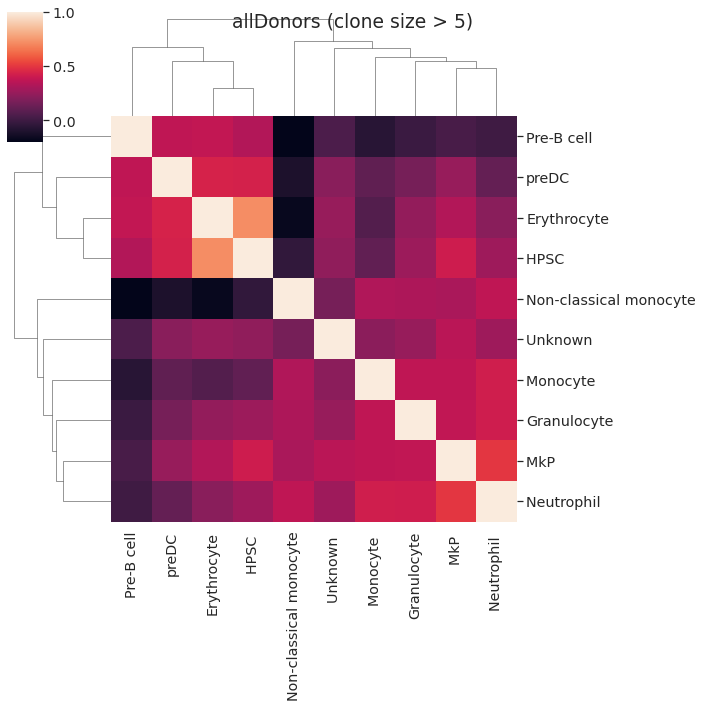

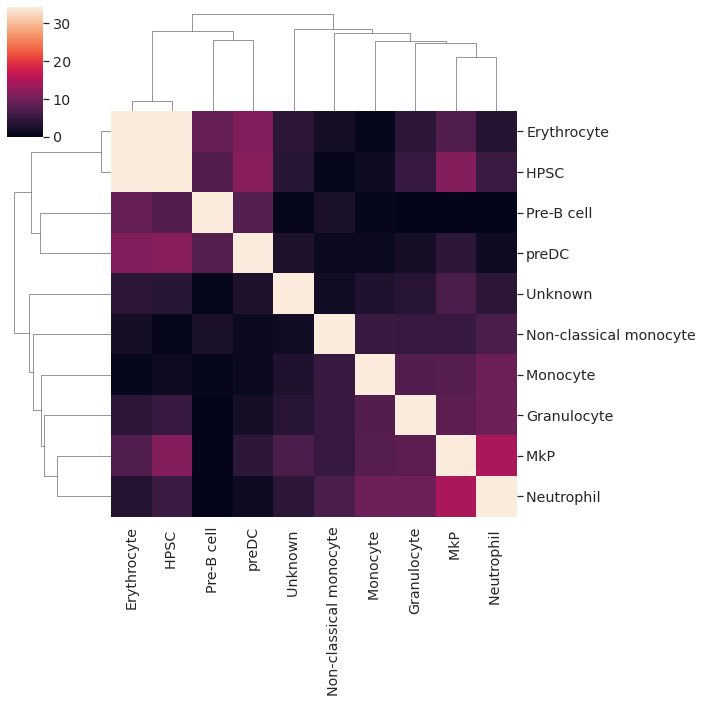

In [12]:
filt_clone_counts_df = convert_log2(keep_top_clones(clone_counts_df, min_cell=min_cell))
filt_clone_counts_df


all_corr_df, all_pval_df = get_corr(filt_clone_counts_df, corr_method)

all_corr_df
sns.clustermap(all_corr_df)
plt.suptitle(f"allDonors (clone size > {min_cell})")
hs(join(outdir, "fateCorr_allDonors.png"), to_pdf=True)

all_corr_df.to_csv(join(outdir, "correlation.csv"))

all_pval_vector = all_pval_df.values.flatten()
all_pval_vector = all_pval_vector[all_pval_vector!=0]
all_min_pval = all_pval_vector.min()
all_min_pval

all_log10pval_df = -np.log10(all_pval_df.apply(lambda x: x.apply(lambda y: all_min_pval if y < all_min_pval else y)))
all_log10pval_df
sns.clustermap(all_log10pval_df)#, mask = all_log10pval_df<1)

[                     0         1                                    comp
 name                                                                    
 CHIP_b1_0_0   4.754888  8.219169  Erythrocyte__HPSC  (kendall_b r=0.716)
 CHIP_b1_1_0   5.129283  7.774787  Erythrocyte__HPSC  (kendall_b r=0.716)
 CHIP_b1_0_1   4.392317  7.584963  Erythrocyte__HPSC  (kendall_b r=0.716)
 CHIP_b2_1_26  4.754888  7.507795  Erythrocyte__HPSC  (kendall_b r=0.716)
 CHIP_b2_1_0   5.129283  7.366322  Erythrocyte__HPSC  (kendall_b r=0.716)
 ...                ...       ...                                     ...
 CHIP_a1_0_29  0.000000  1.584963  Erythrocyte__HPSC  (kendall_b r=0.716)
 CHIP_b2_0_34  0.000000  2.321928  Erythrocyte__HPSC  (kendall_b r=0.716)
 CHIP_a1_4_0   0.000000  0.000000  Erythrocyte__HPSC  (kendall_b r=0.716)
 CHIP_a1_0_14  0.000000  1.584963  Erythrocyte__HPSC  (kendall_b r=0.716)
 CHIP_b2_0_32  0.000000  2.807355  Erythrocyte__HPSC  (kendall_b r=0.716)
 
 [148 rows x 3 columns],
           

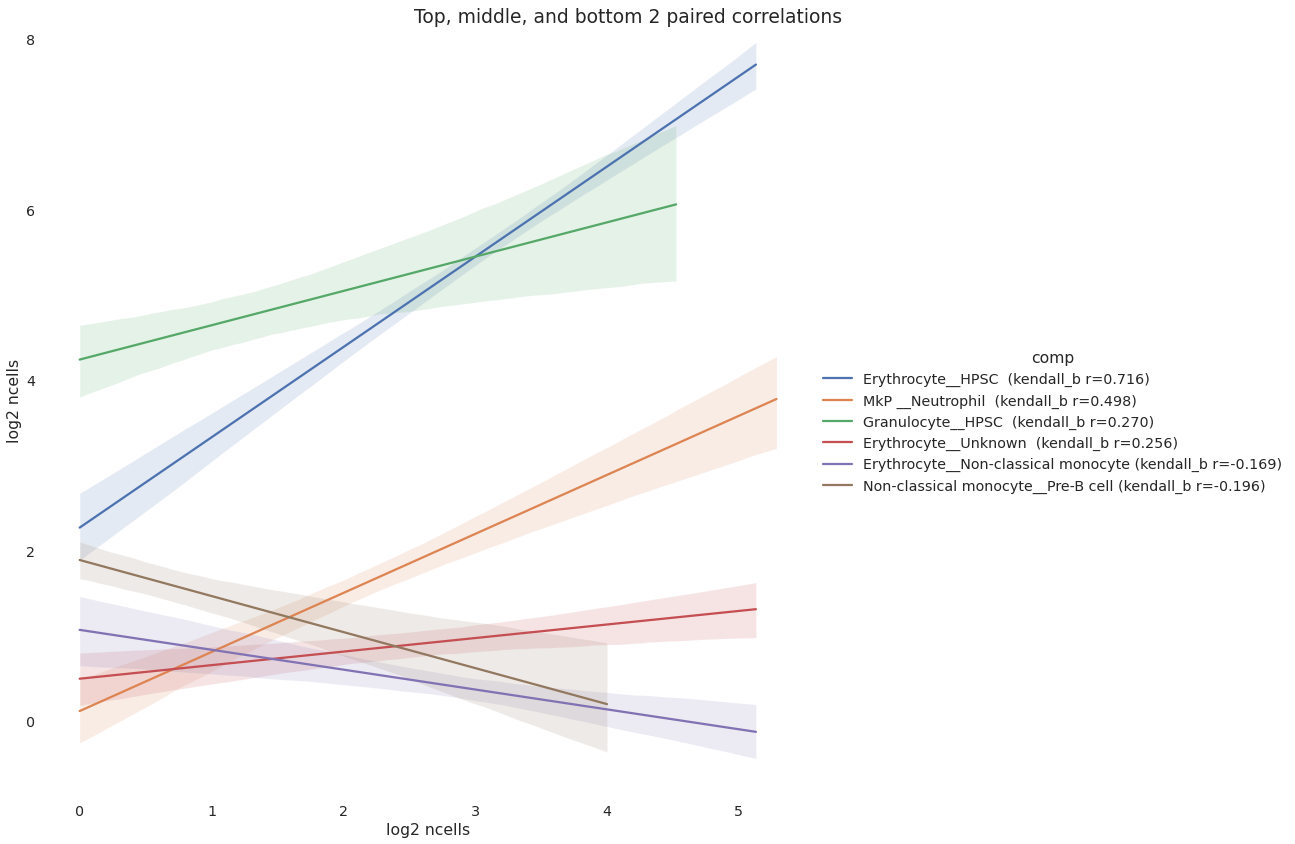

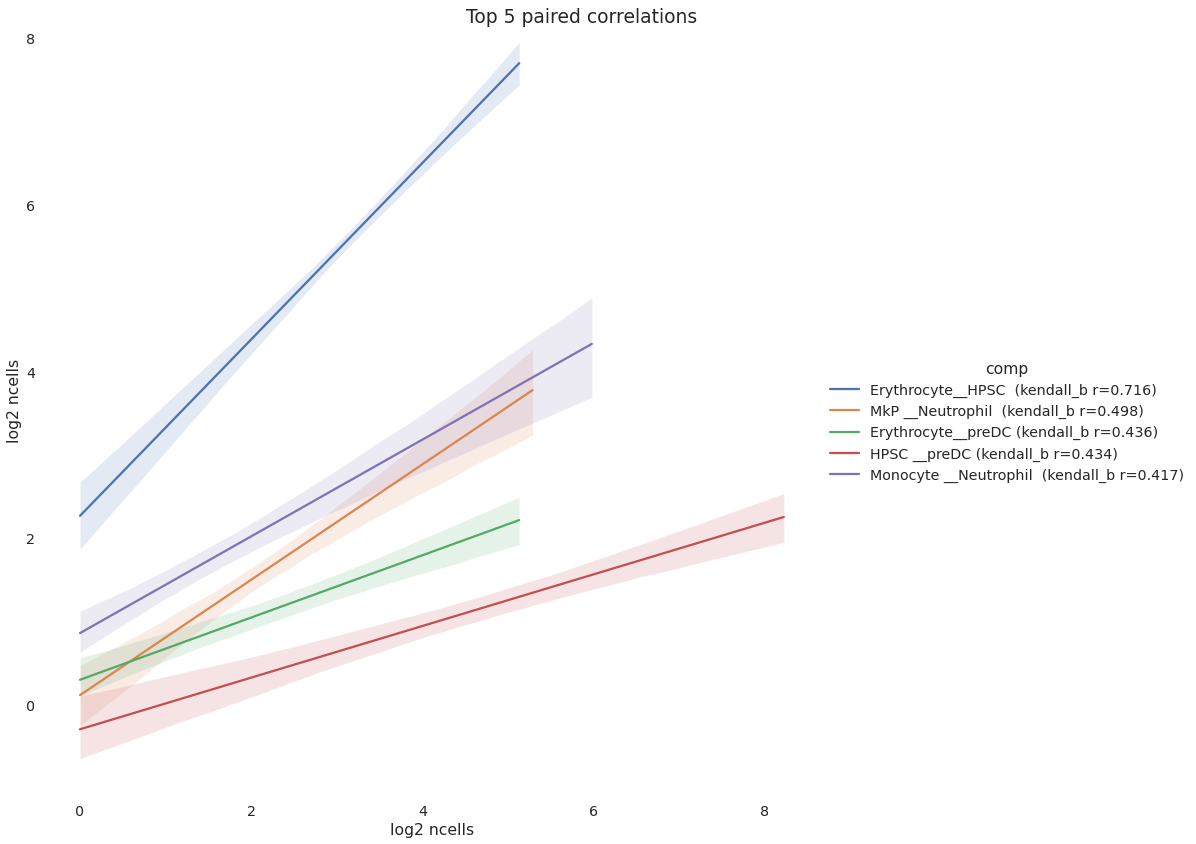

In [13]:
plot_repr_corr(filt_clone_counts_df, all_corr_df, label="log2 ncells", 
               out_f=join(outdir,"fateCorr_scatter_allDonors.png"))

plot_repr_corr(filt_clone_counts_df, all_corr_df, label="log2 ncells", top=True,
               out_f=join(outdir,"top_fateCorr_scatter_allDonors.png"))

### b) Separate donors, min_cell=min_cell

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metr

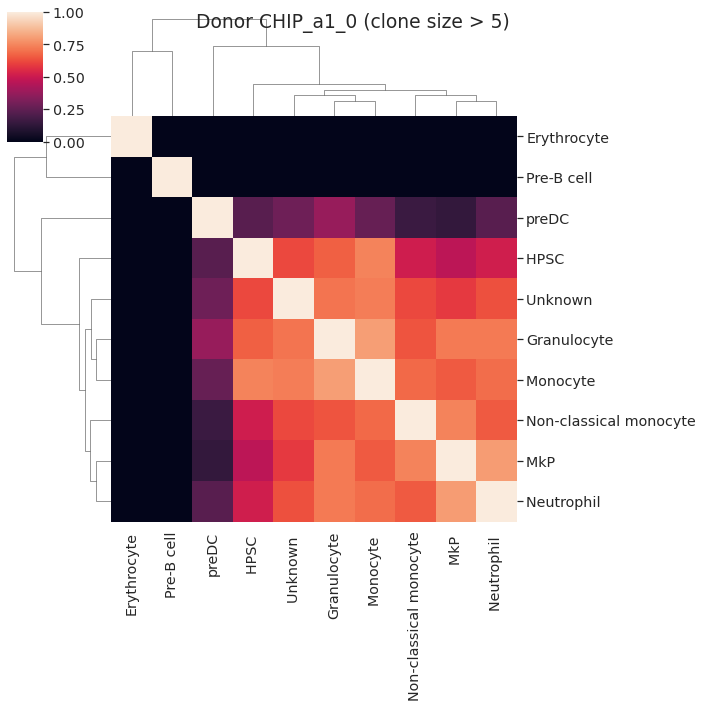

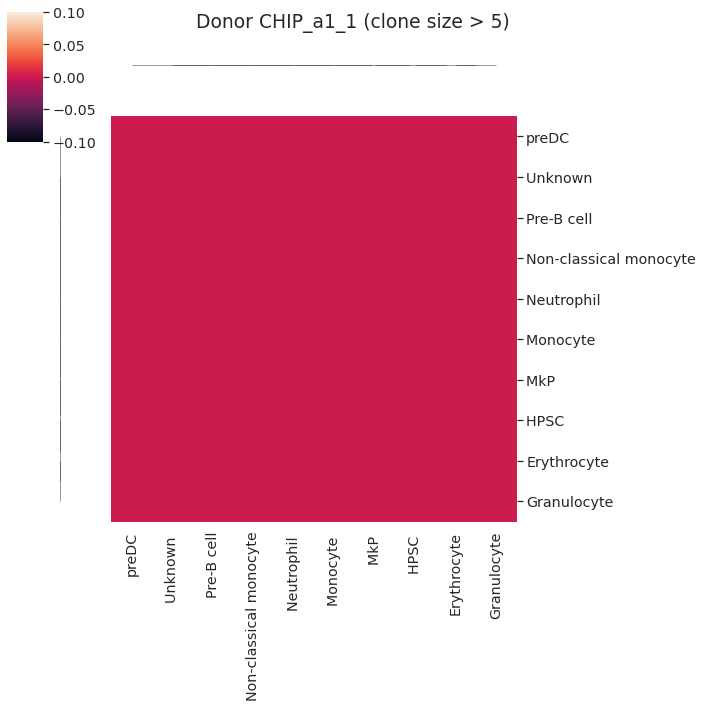

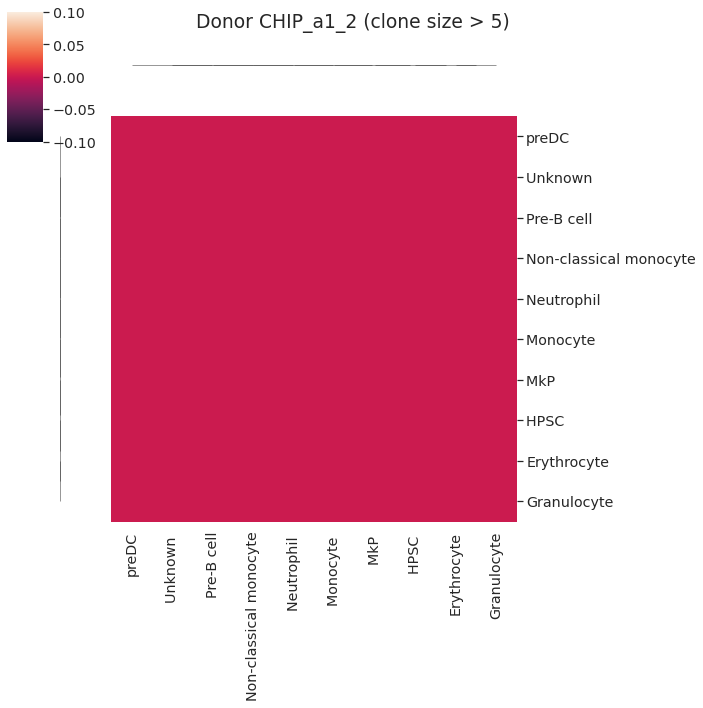

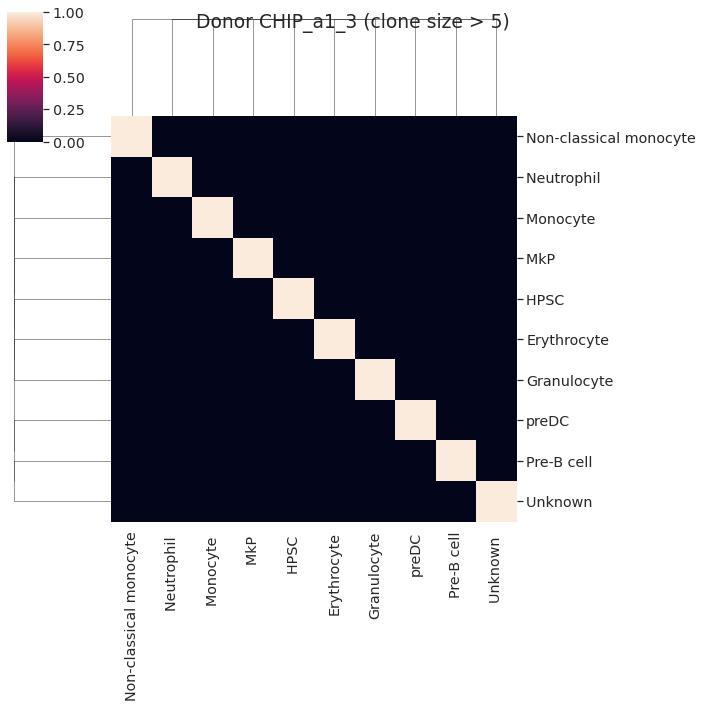

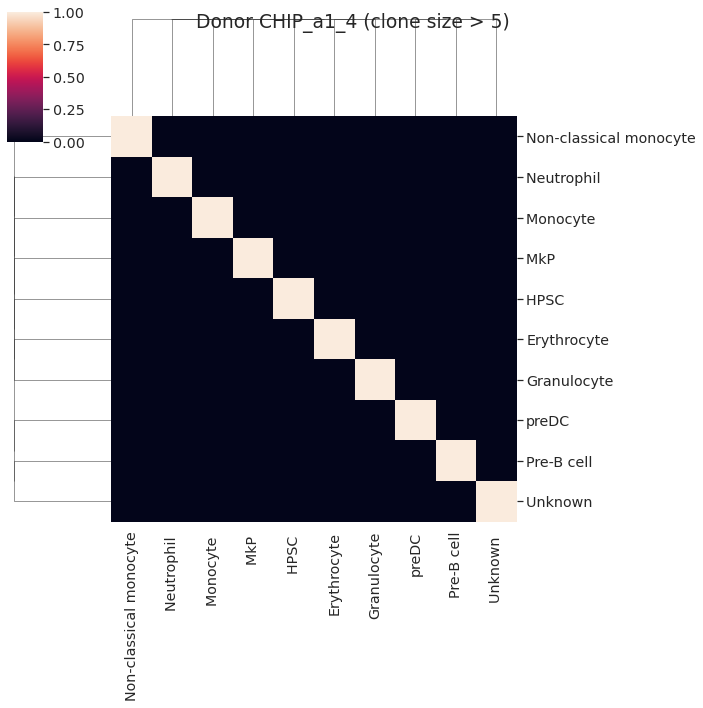

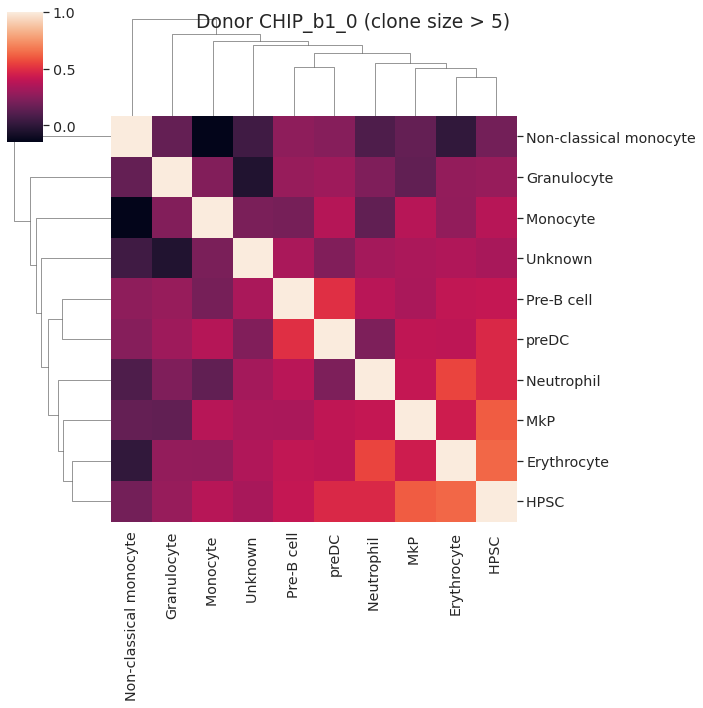

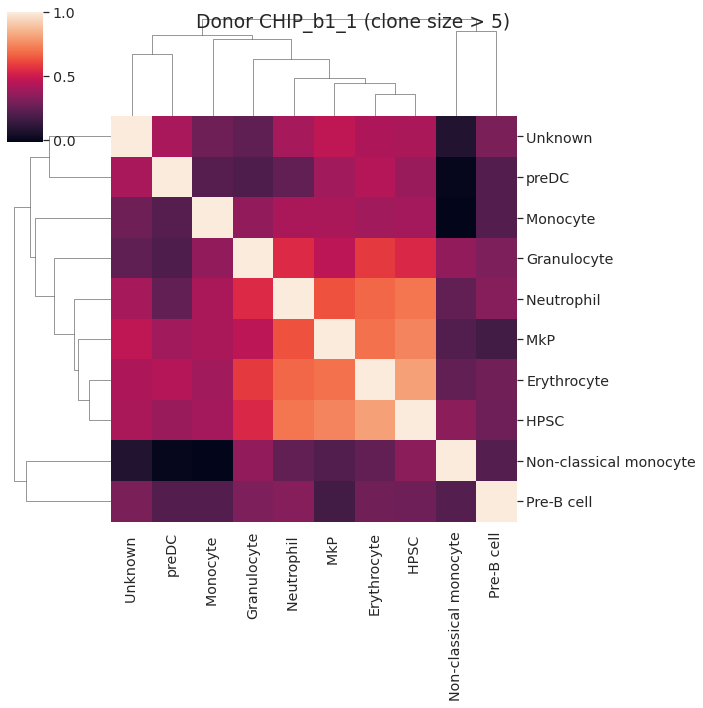

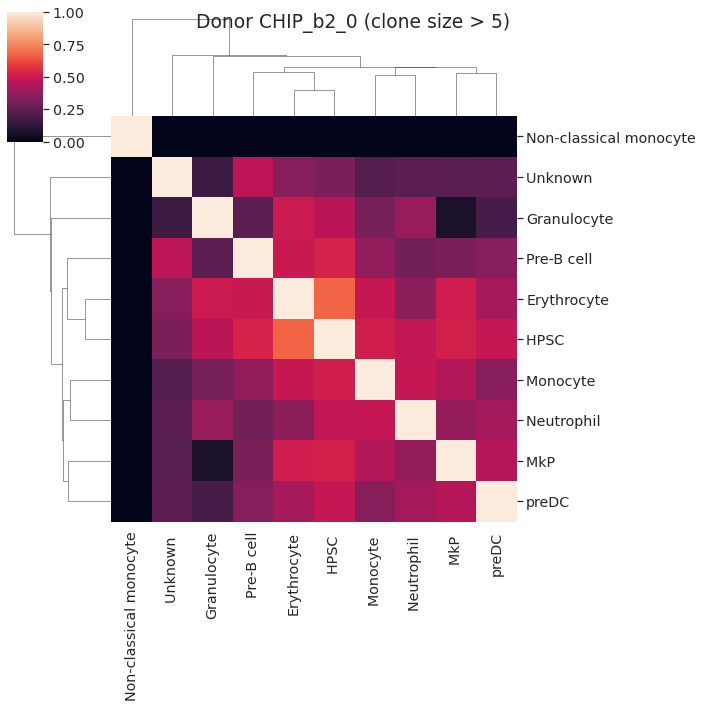

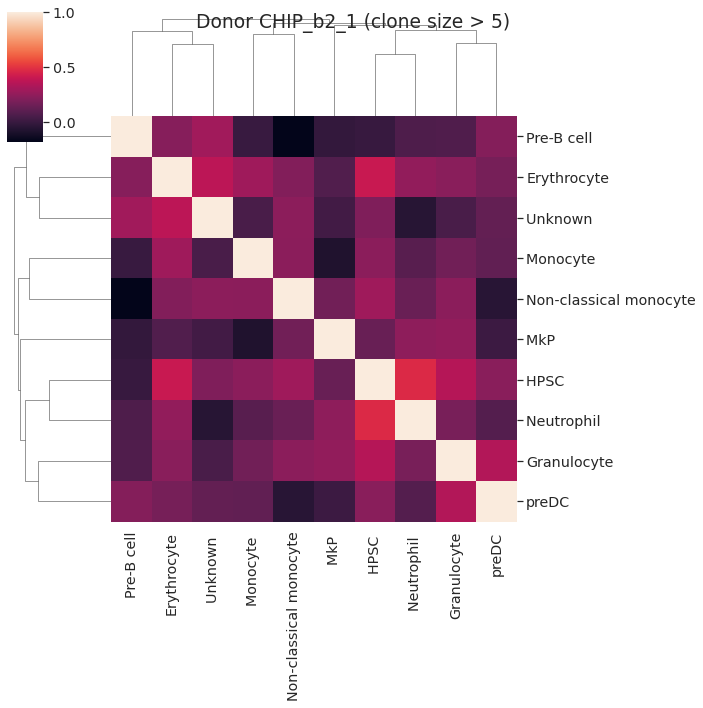

In [14]:
for don, val in clone_counts_df.groupby("donor"):
    tmp = keep_top_clones(val, min_cell=min_cell)
    #corr_df = np.log2(1+tmp.drop(["ncells", "donor"],axis=1)).corr(method="spearman")
    corr_df, pval_df = get_corr(tmp, corr_method)
    corr_df

    sns.clustermap(corr_df)
    plt.suptitle(f"Donor {don} (clone size > {min_cell})")
    hs(join(outdir, f"fateCorr_donor{don}.png"), to_pdf=True)


### c) Separate donors, min_cell is 50

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


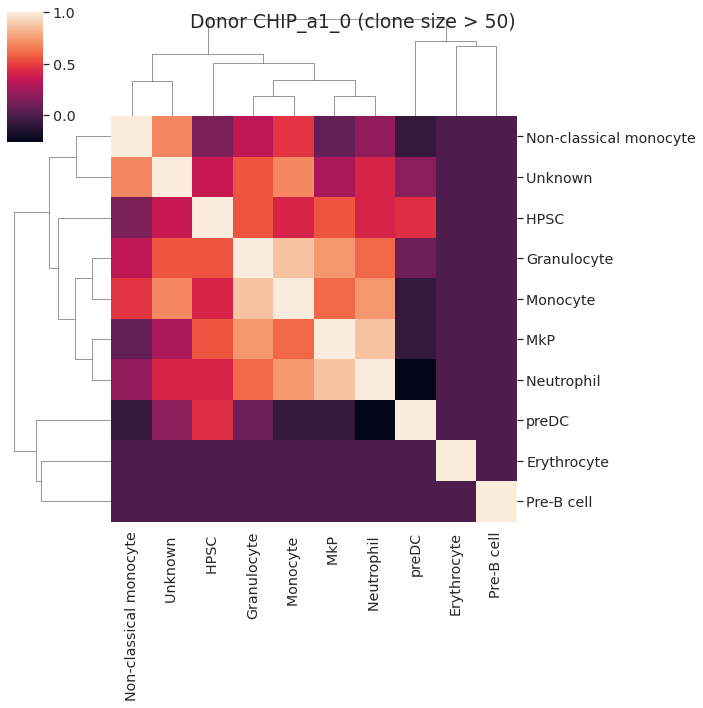

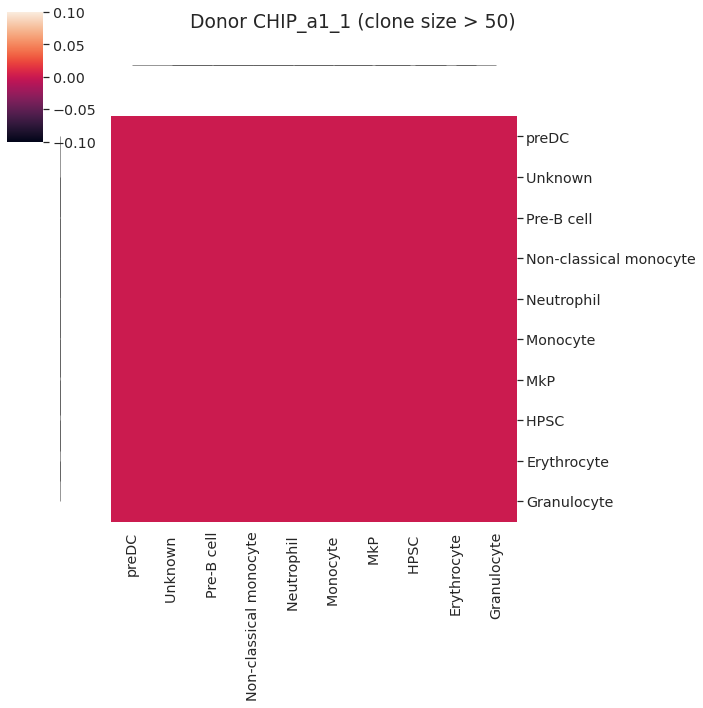

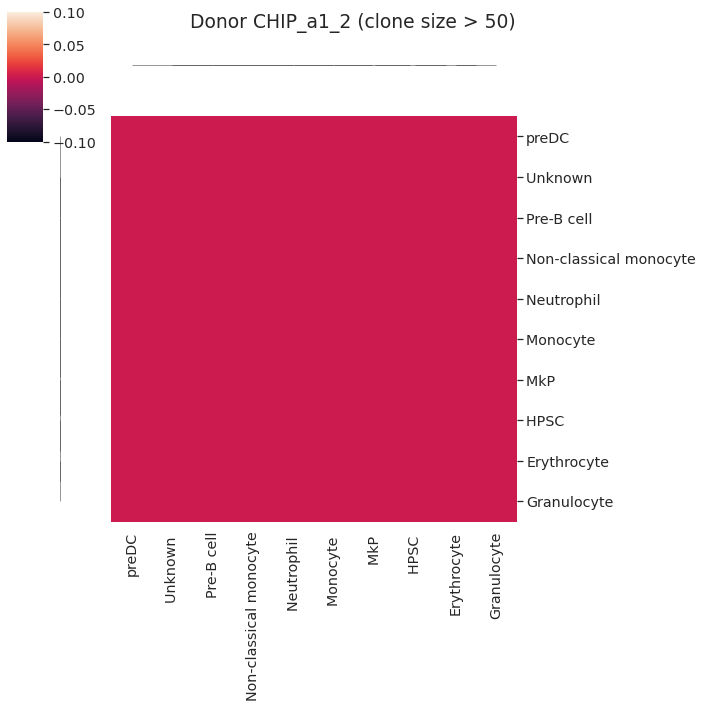

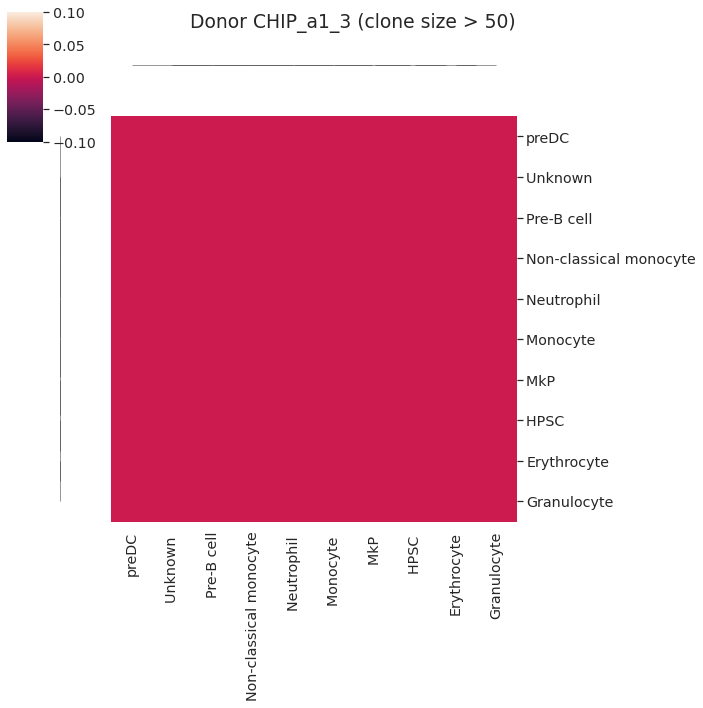

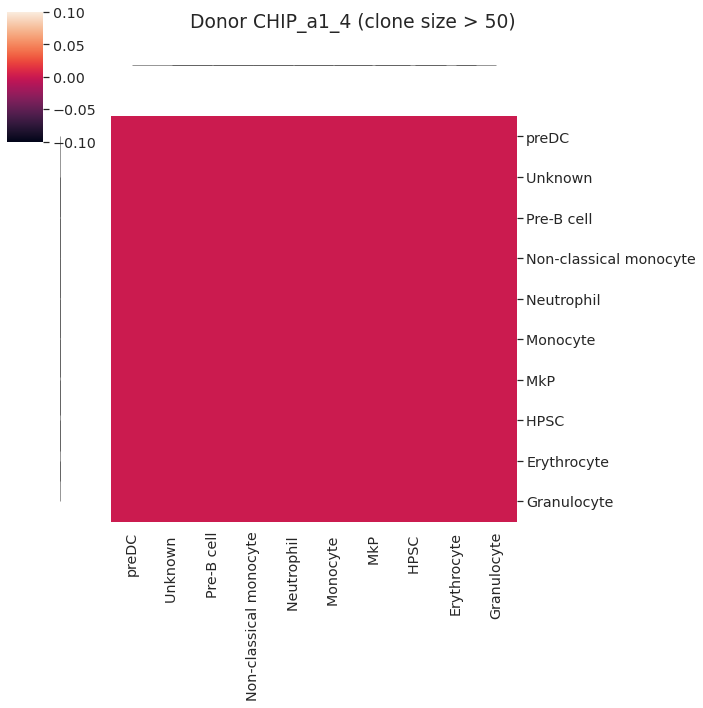

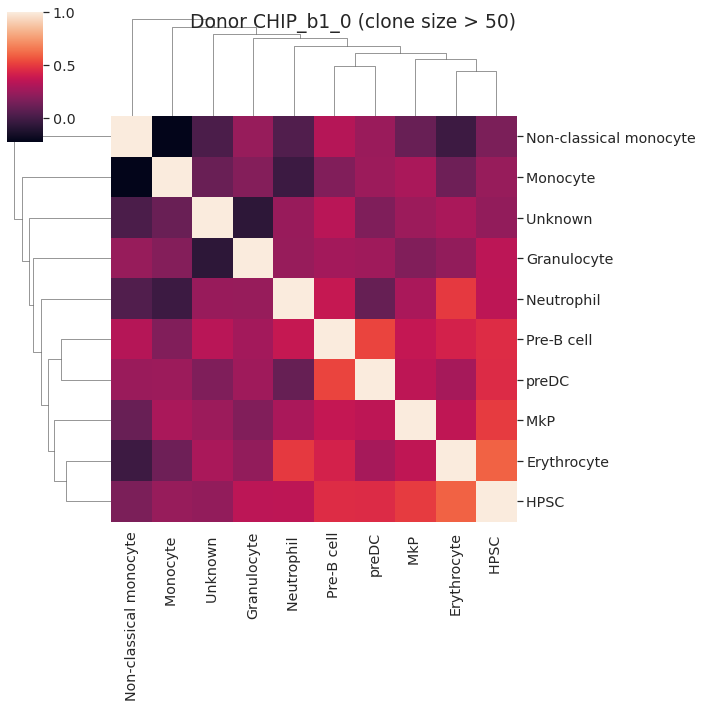

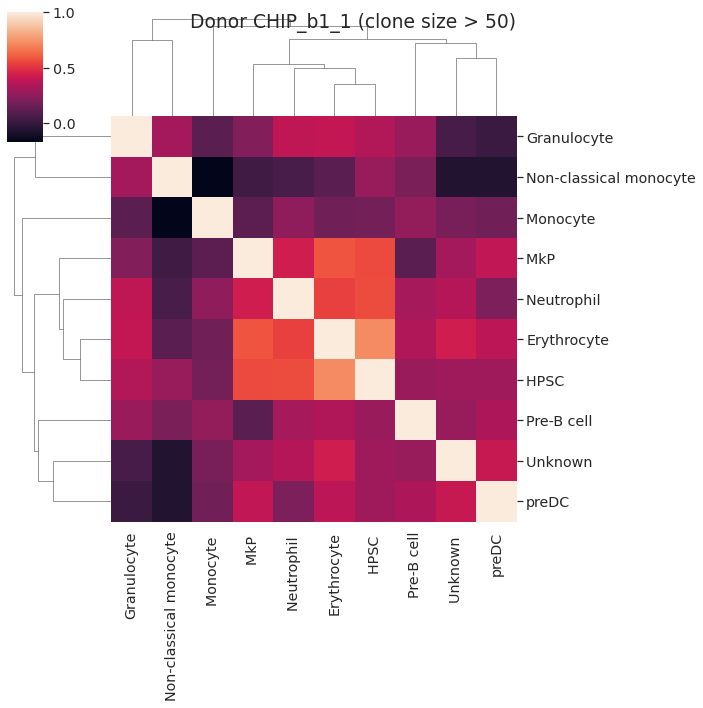

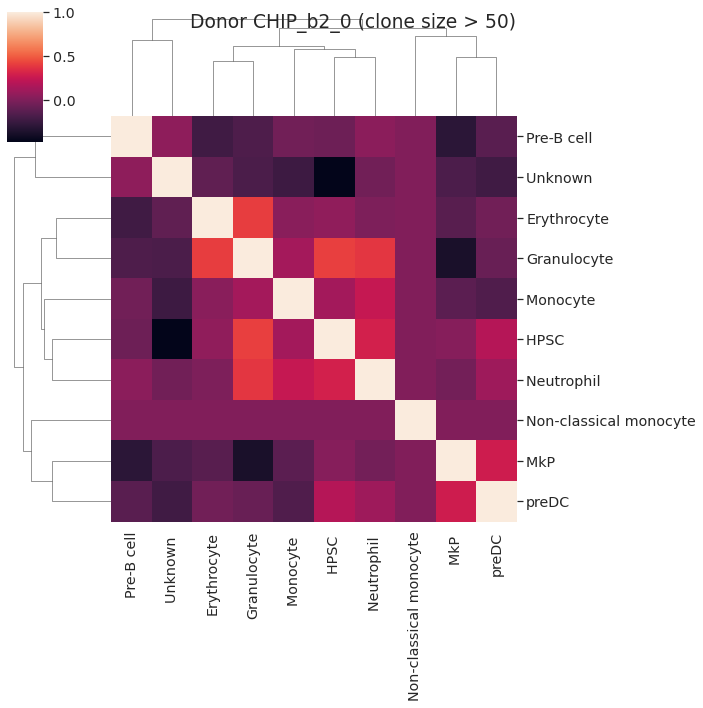

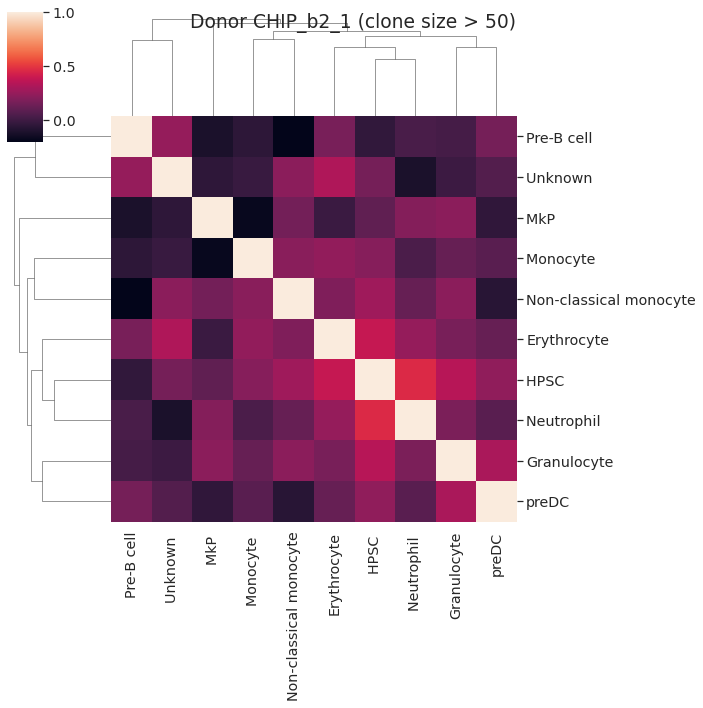

In [15]:
for don, val in clone_counts_df.groupby("donor"):
    tmp = keep_top_clones(val, min_cell=50)
    #corr_df = np.log2(1+tmp.drop(["ncells", "donor"],axis=1)).corr(method="spearman")
    corr_df, pval_df = get_corr(tmp, corr_method)
    corr_df

    sns.clustermap(corr_df)
    plt.suptitle(f"Donor {don} (clone size > 50)")

## Separate donors, no min_cell

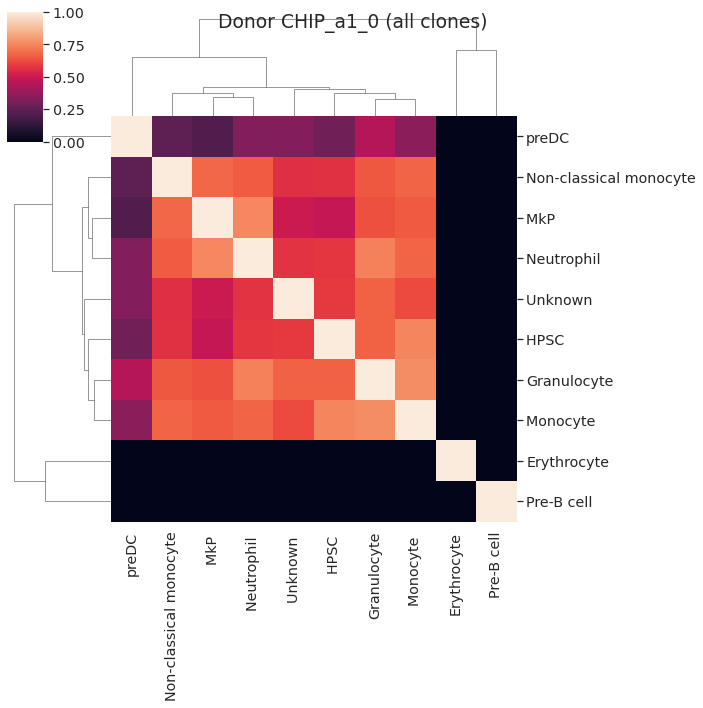

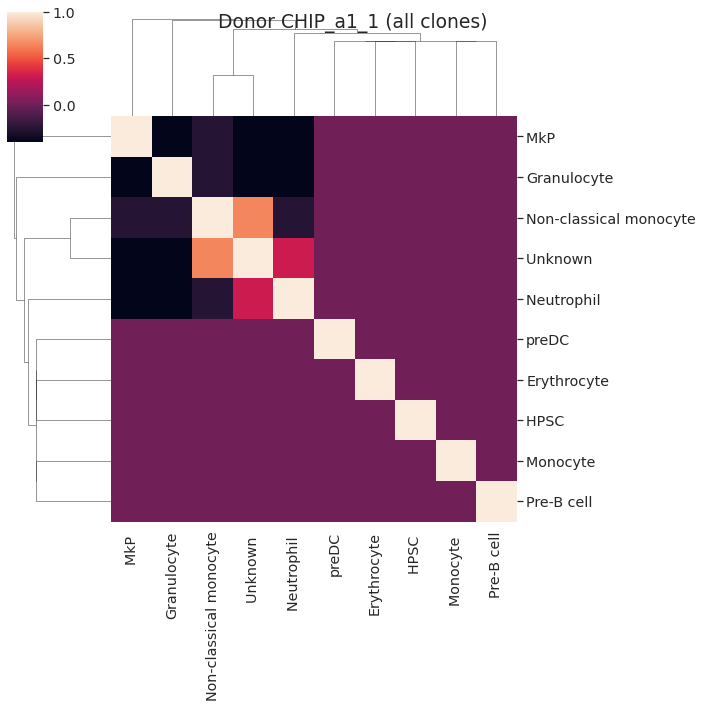

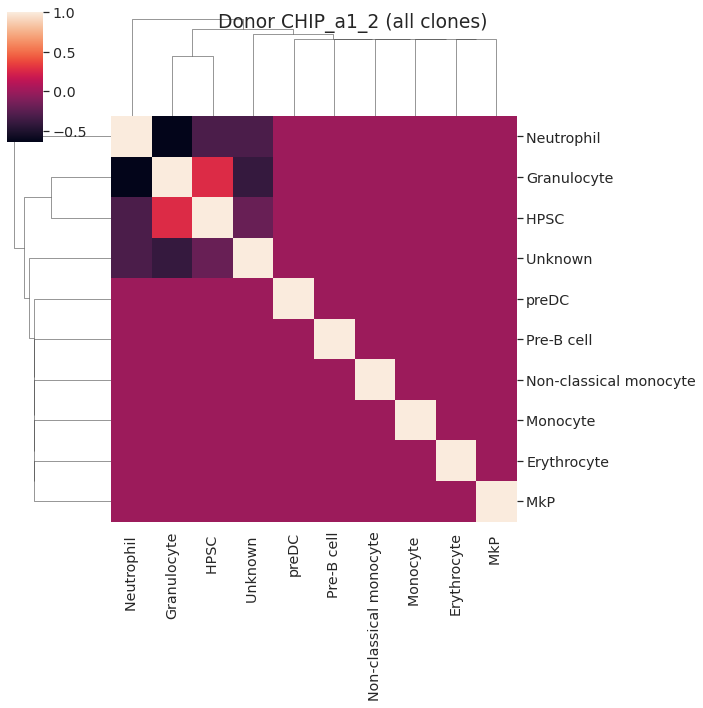

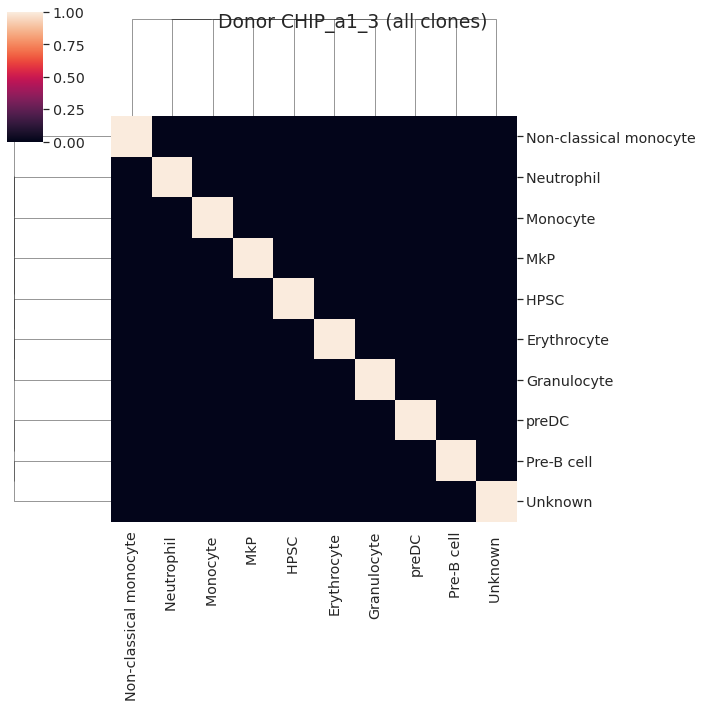

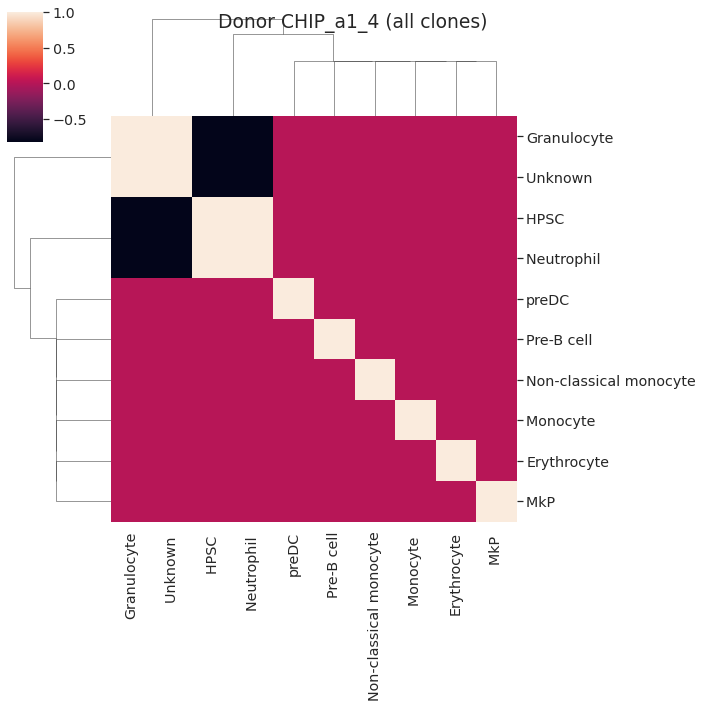

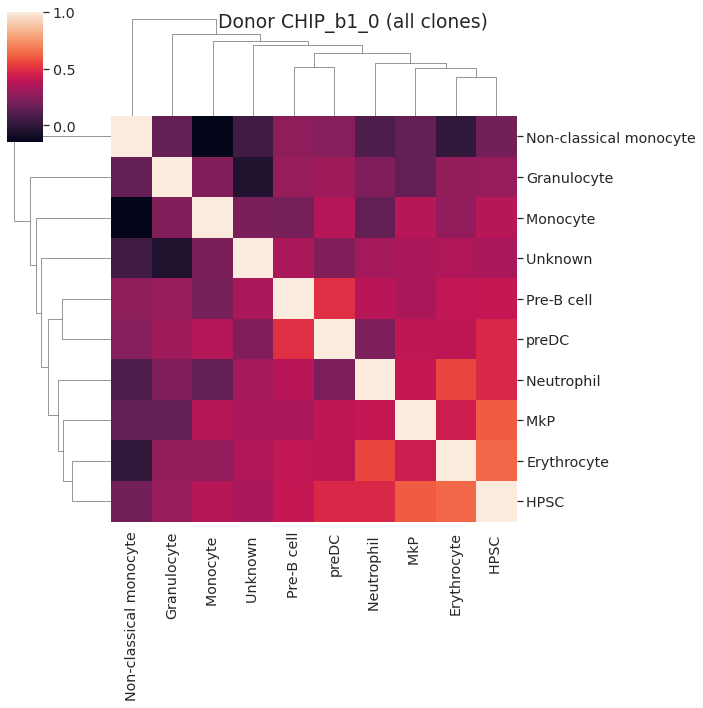

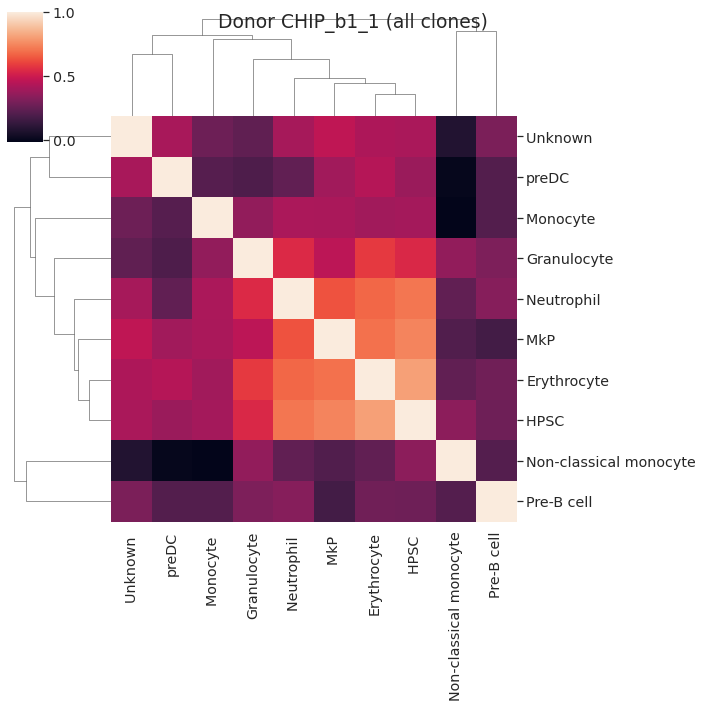

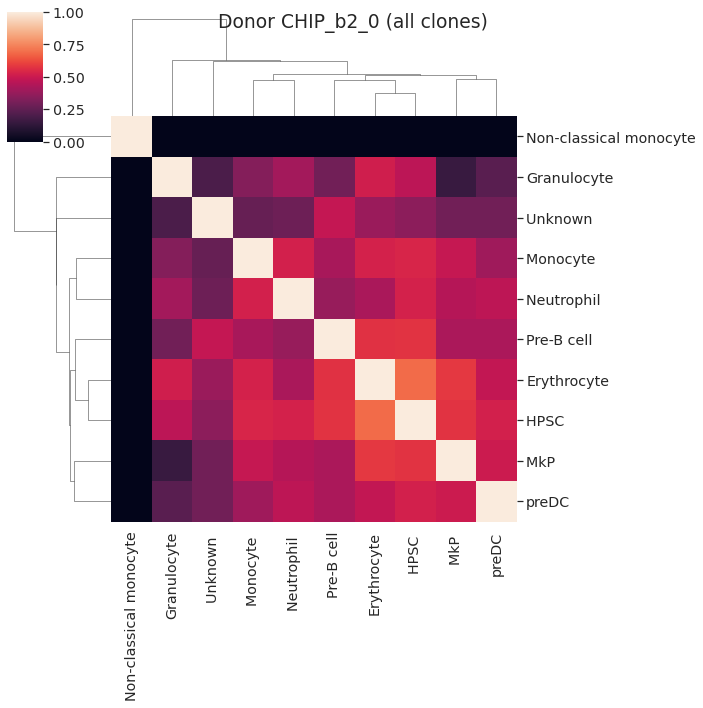

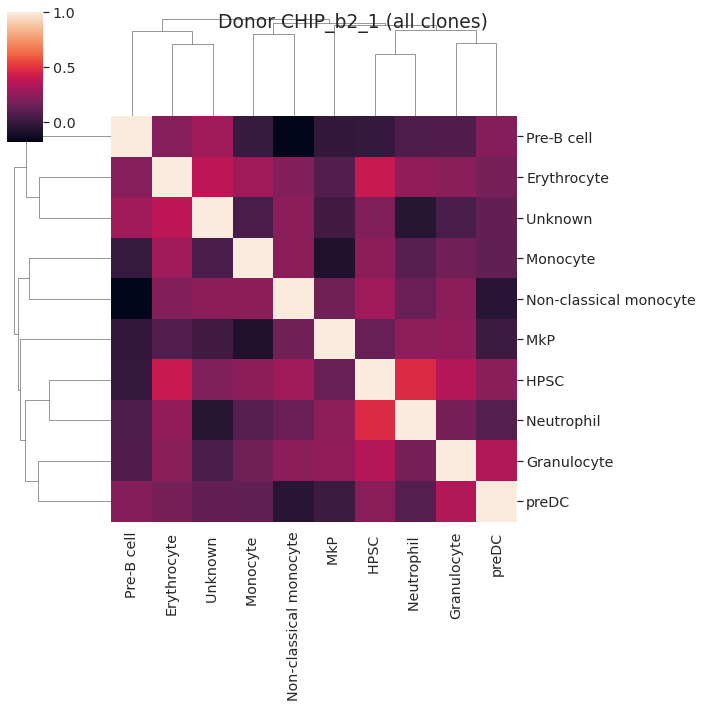

In [16]:
for don, val in clone_counts_df.groupby("donor"):
    tmp = keep_top_clones(val, min_cell=0)
    #corr_df = np.log2(1+val.drop(["ncells", "donor"],axis=1)).corr(method="spearman")
    corr_df, pval_df = get_corr(val, corr_method)
    sns.clustermap(corr_df)
    plt.suptitle(f"Donor {don} (all clones)")

### d) Normalize per donor, run donors together and separately

[                     0         1  \
 name                               
 CHIP_a1_3_0   0.000000  0.000000   
 CHIP_a1_0_0   0.007334  0.004672   
 CHIP_a1_0_0   0.007334  0.004672   
 CHIP_a1_0_0   0.007334  0.004672   
 CHIP_a1_0_2   0.006021  0.004908   
 ...                ...       ...   
 CHIP_b1_0_13  0.000000  0.000000   
 CHIP_b1_0_7   0.000000  0.000000   
 CHIP_b1_0_9   0.000000  0.000000   
 CHIP_b1_0_8   0.000000  0.000000   
 CHIP_b1_0_3   0.000000  0.000000   
 
                                                            comp  
 name                                                             
 CHIP_a1_3_0   Monocyte __Non-classical monocyte (kendall_b r...  
 CHIP_a1_0_0   Monocyte __Non-classical monocyte (kendall_b r...  
 CHIP_a1_0_0   Monocyte __Non-classical monocyte (kendall_b r...  
 CHIP_a1_0_0   Monocyte __Non-classical monocyte (kendall_b r...  
 CHIP_a1_0_2   Monocyte __Non-classical monocyte (kendall_b r...  
 ...                                            

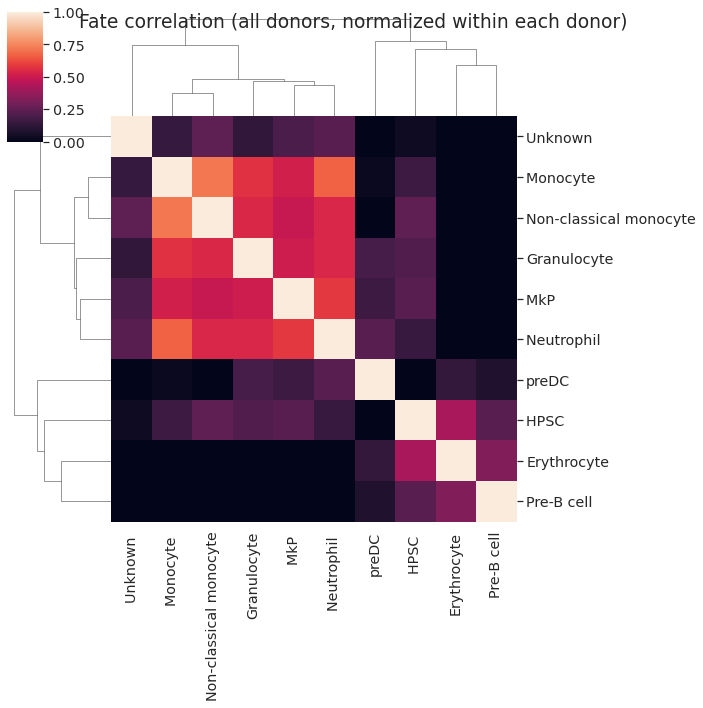

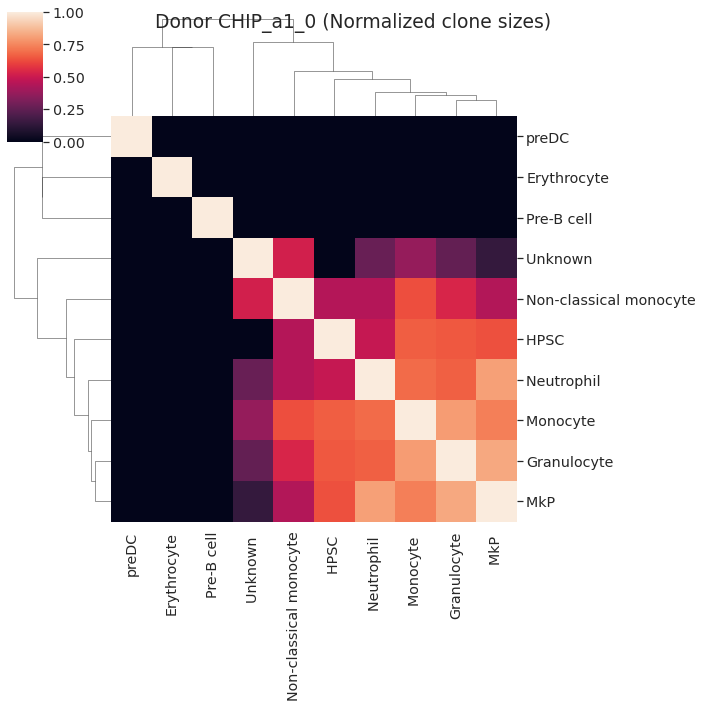

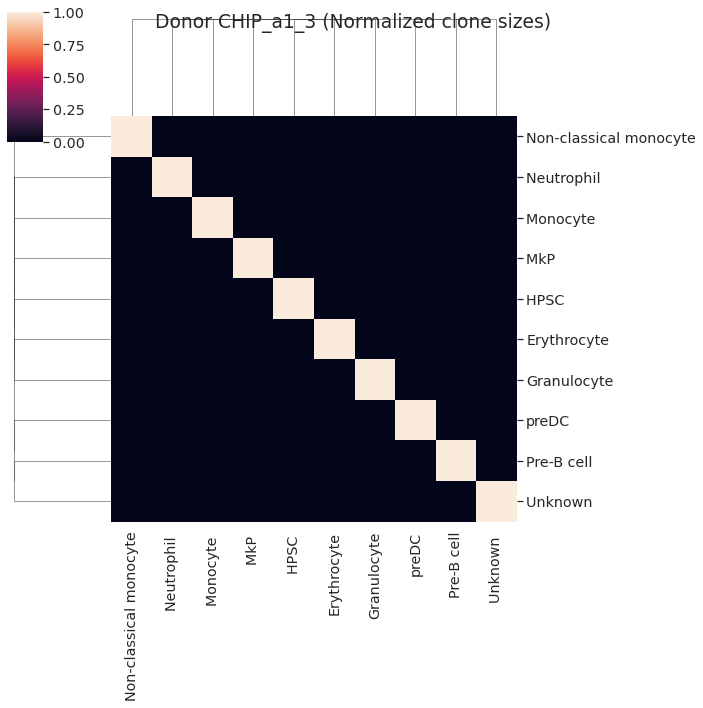

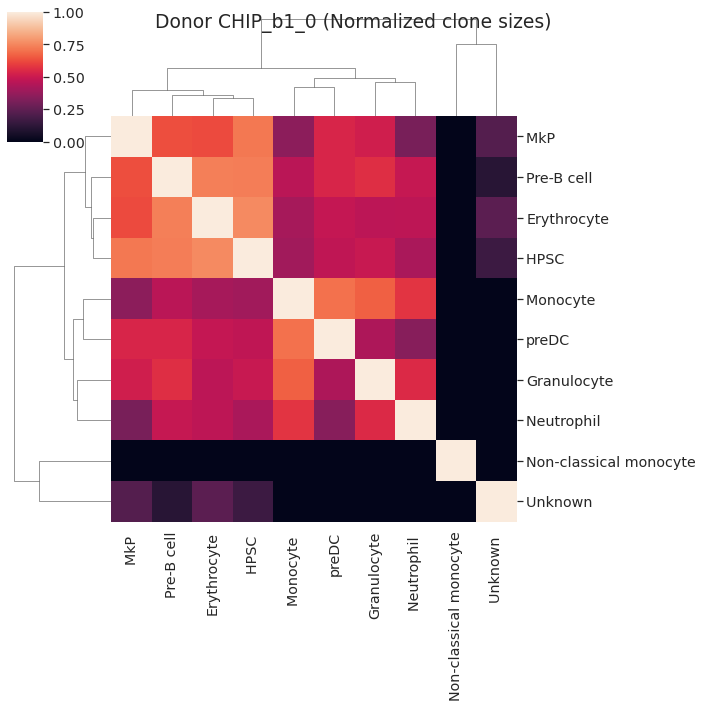

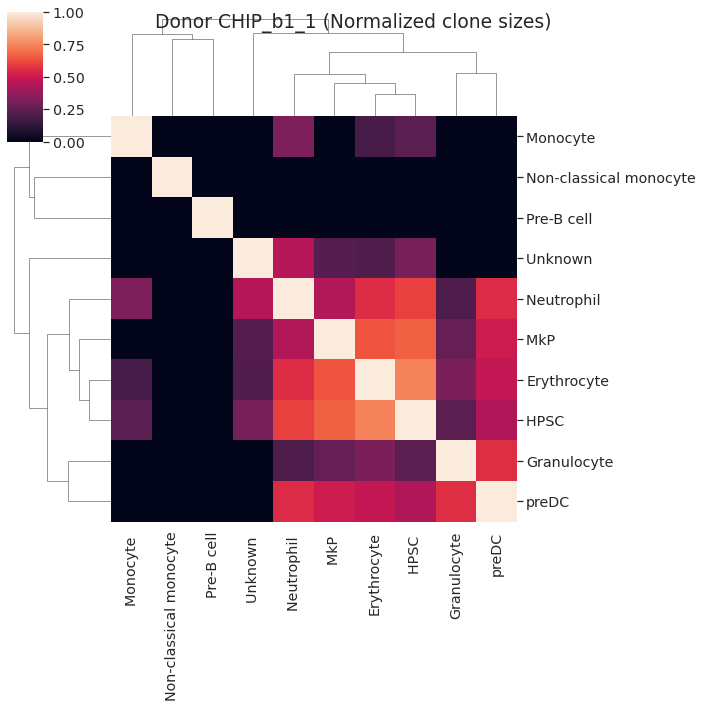

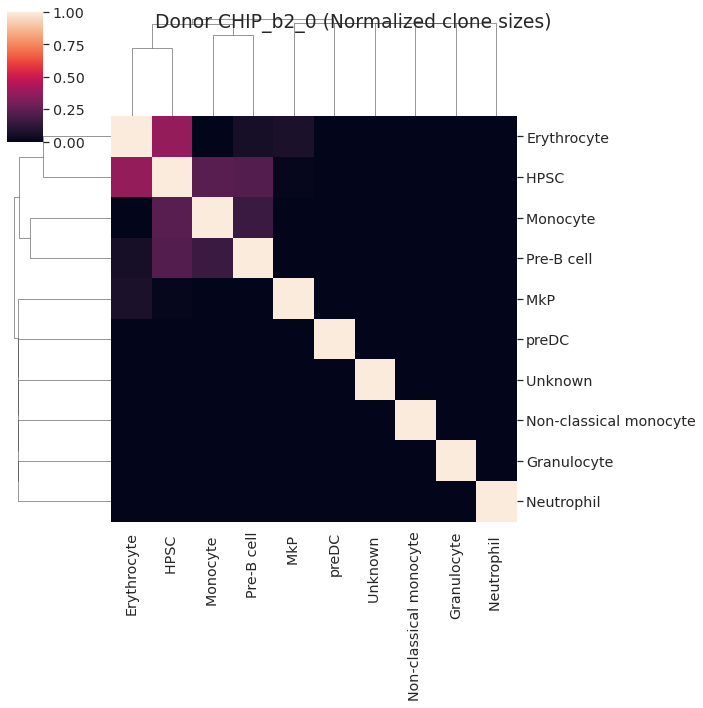

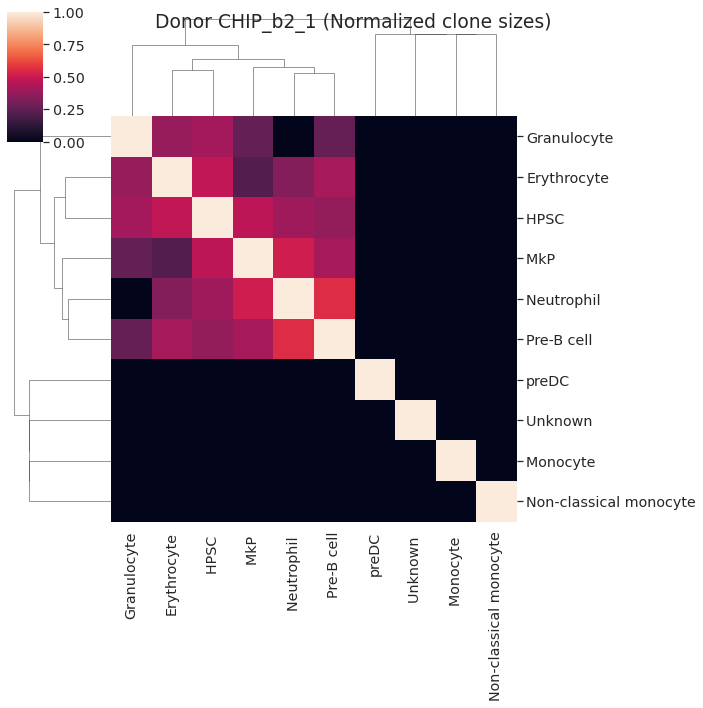

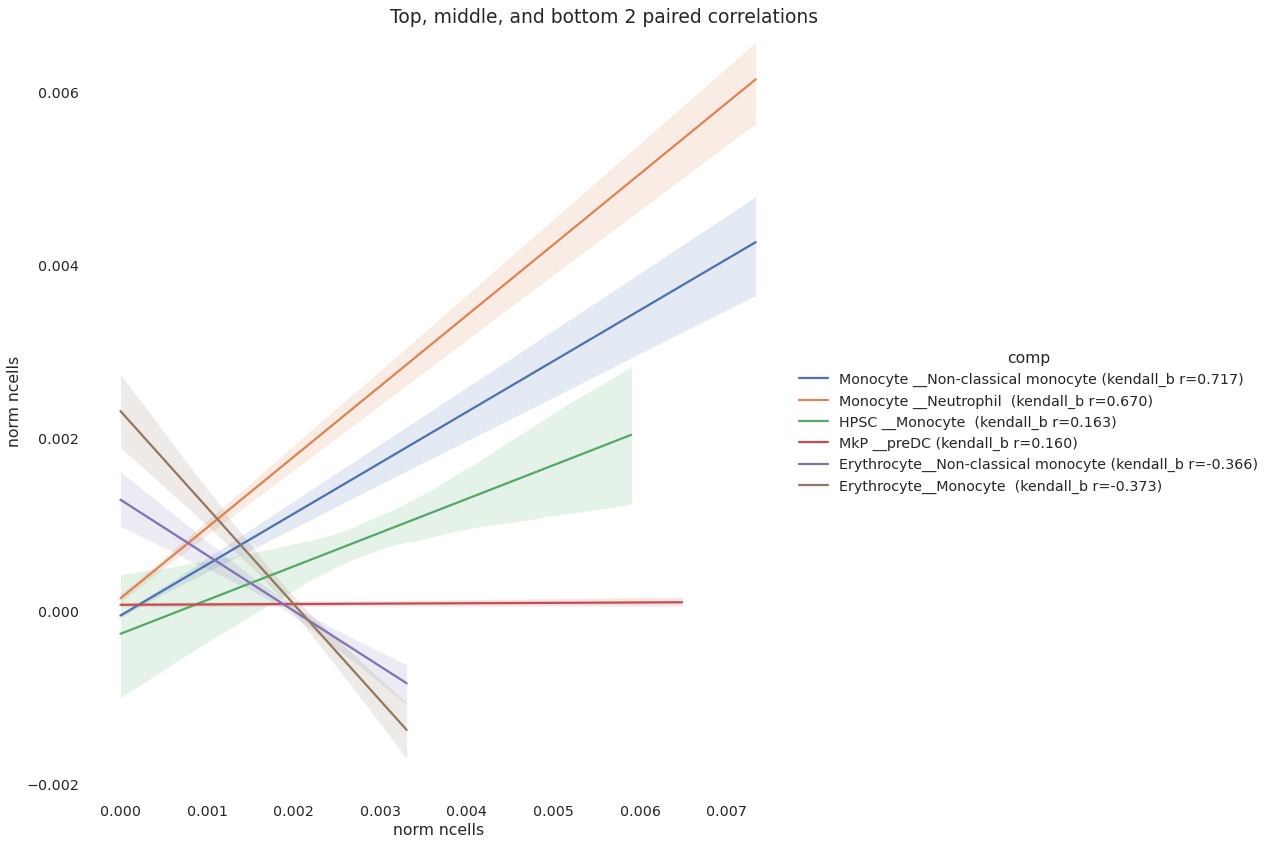

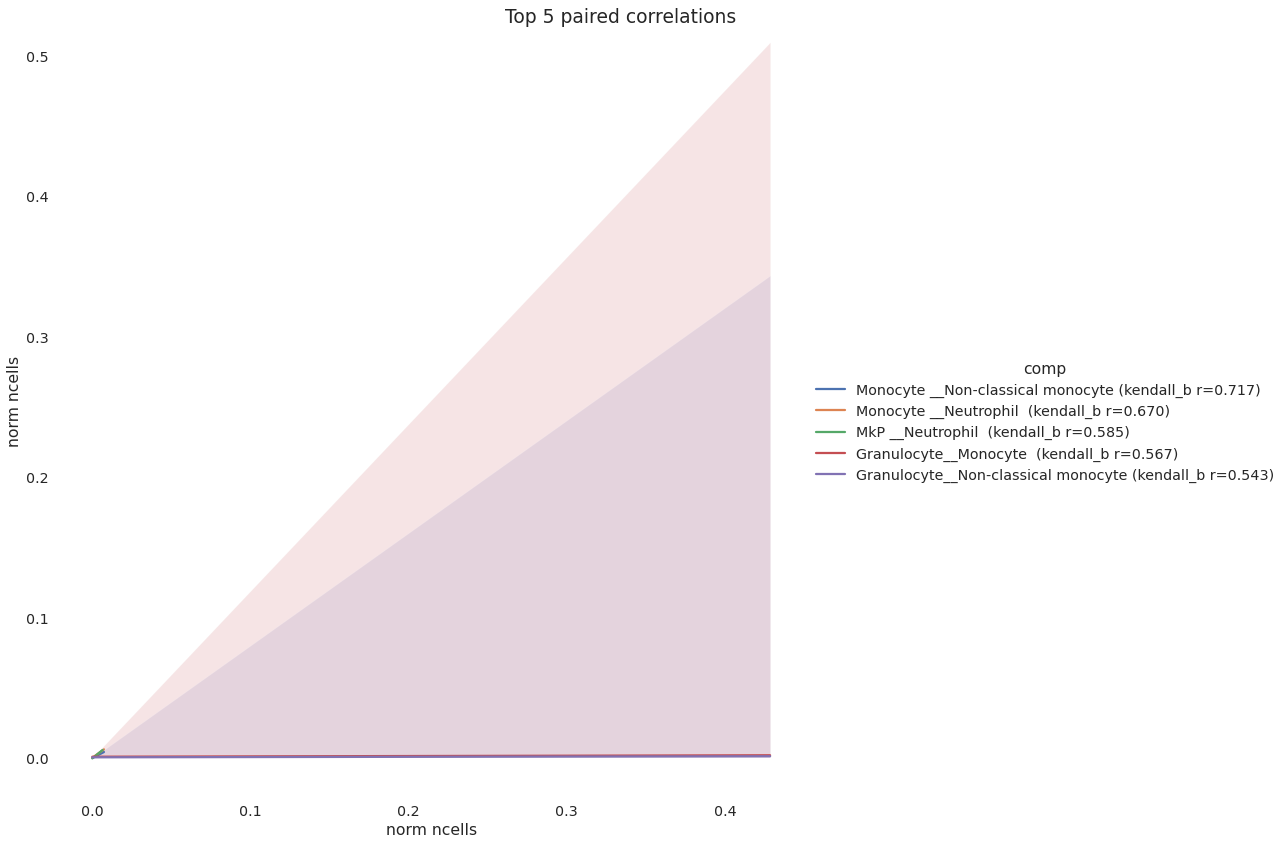

In [17]:
filt_clone_counts = keep_top_clones(clone_counts, min_cell=min_cell)
filt_clone_counts


clone_norm = filt_clone_counts.copy()

#clone_sums = clone_counts.groupby("name").sum()["ncells"]

clone_norm["ncells"] = np.log2(1+clone_norm["ncells"])
clone_sums = filt_clone_counts.groupby(["donor"]).sum()["ncells"]

clone_norm["ncells"] = clone_norm.apply(lambda x: x["ncells"]/clone_sums.loc[(x["donor"])] , axis=1)
clone_norm = clone_norm[~(clone_norm["name"]=="None")]
clone_norm_combined = clone_norm.groupby(["name", "donor", "nuclear_clusters"]).sum()["ncells"].reset_index().sort_values("ncells", ascending=False).set_index("name")
clone_norm_combined



clone_norm_df = pd.concat((clone_norm_combined, clone_norm_combined.apply(get_clone_count, axis=1, args=(clone_norm,))),axis=1).fillna(0)
#norm_corr_df = clone_norm_df.drop(["ncells", "donor"],axis=1).corr(method="spearman")

norm_corr_df, norm_pval_df = get_corr(clone_norm_df, corr_method)

norm_corr_df.to_csv(join(outdir, "norm_correlation.csv"))


sns.clustermap(norm_corr_df.loc[(~norm_corr_df.isnull().all(axis=1)),(~norm_corr_df.isnull().all())], vmin=0, vmax=1)
plt.suptitle("Fate correlation (all donors, normalized within each donor)")
hs(join(outdir, "norm_allDonors.png"), to_pdf=True)

for don, val in clone_norm_df.groupby("donor"):
    #corr_df = val.drop(["ncells", "donor"],axis=1).corr(method="spearman")
    corr_df, pval_df = get_corr(val, corr_method)
    sns.clustermap(corr_df.loc[(~corr_df.isnull().all(axis=1)),(~corr_df.isnull().all())].fillna(0), vmin=0, vmax=1)
    plt.suptitle(f"Donor {don} (Normalized clone sizes)")

plot_repr_corr(clone_norm_df, norm_corr_df, label="norm ncells", out_f=join(outdir, "norm_fateCorr_scatter_allDonors.png"))

plot_repr_corr(clone_norm_df, norm_corr_df, label="norm ncells", top=True, 
               out_f=join(outdir, "top_norm_fateCorr_scatter_allDonors.png"))

## Normalize but within each clone as well

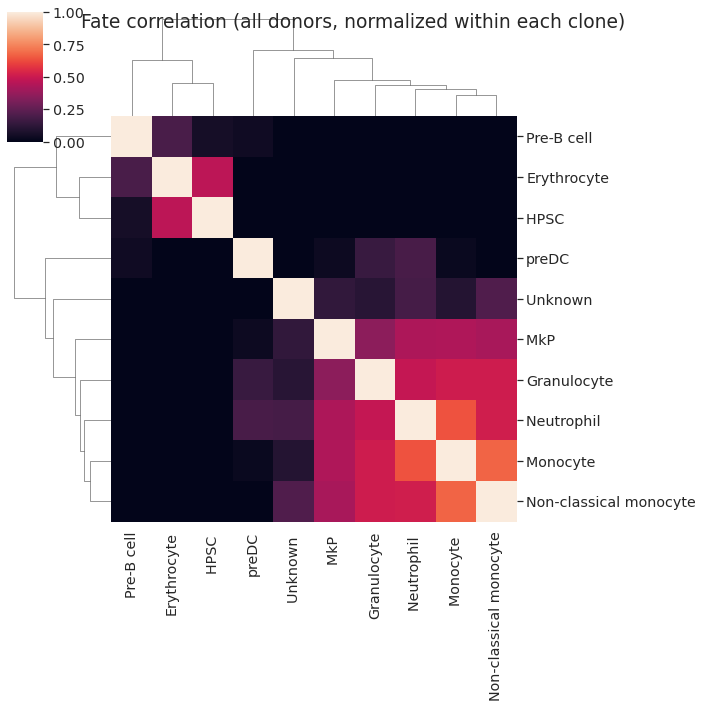

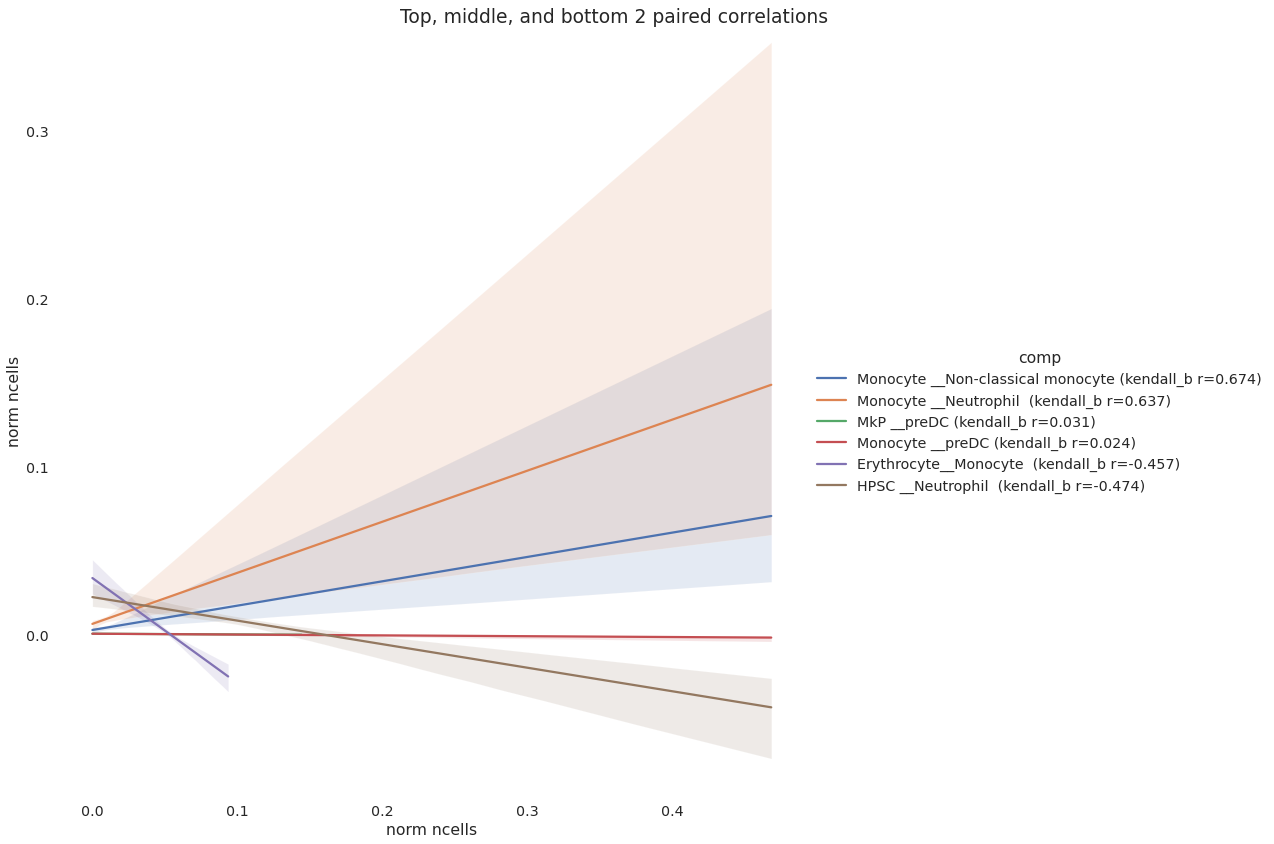

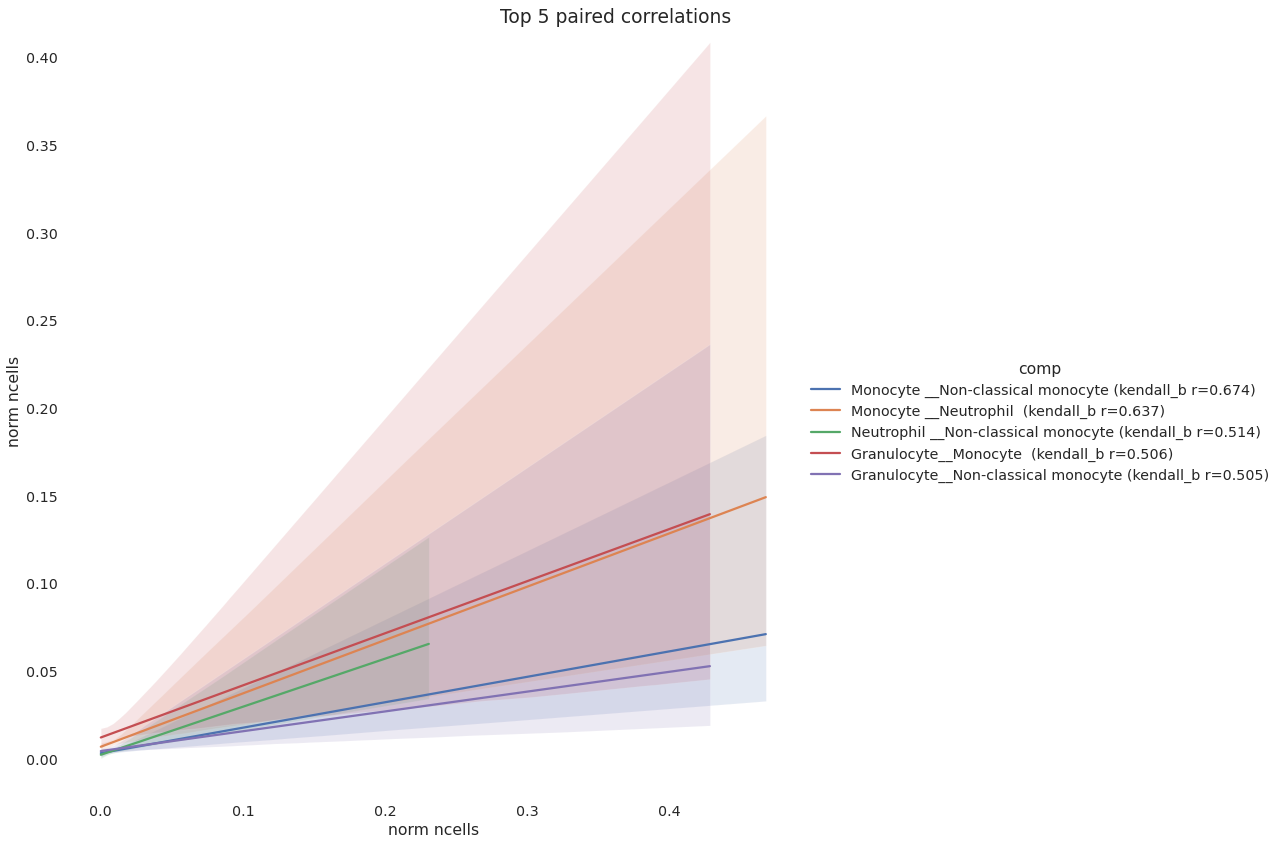

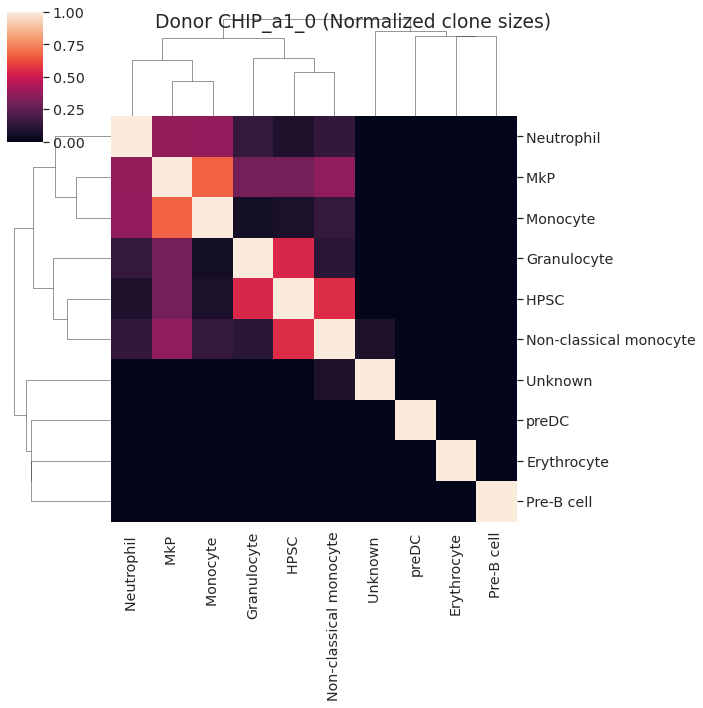

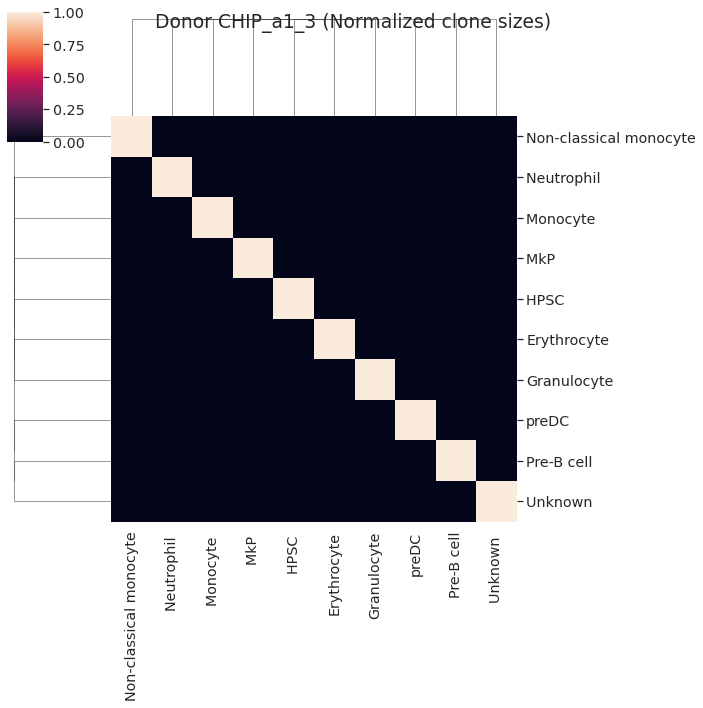

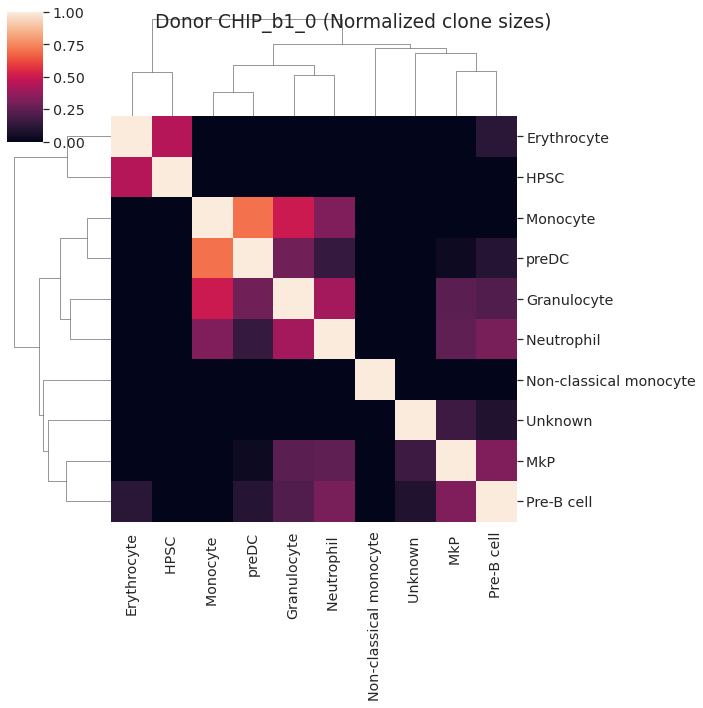

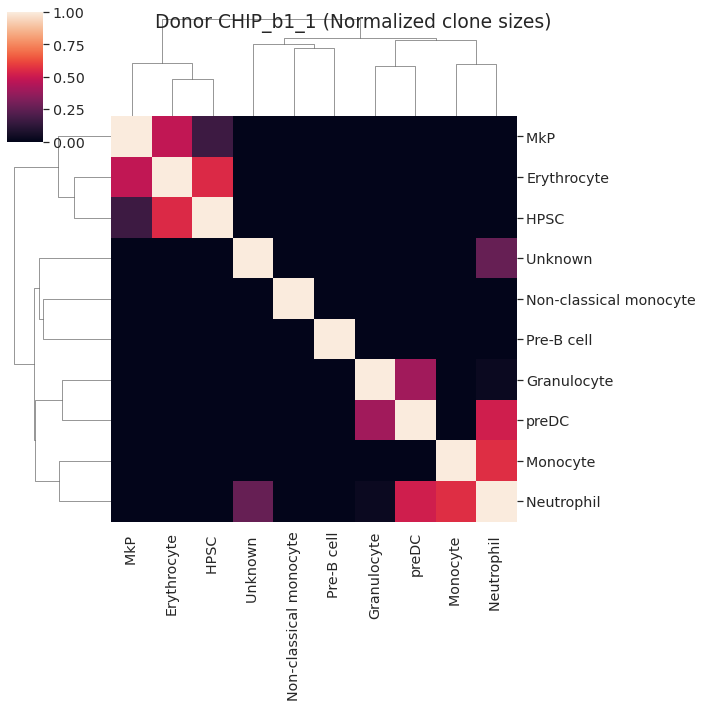

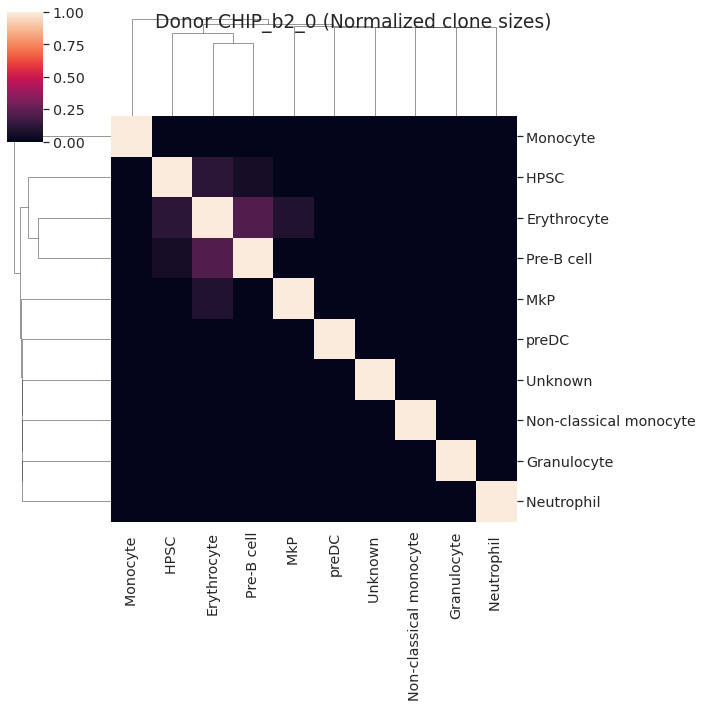

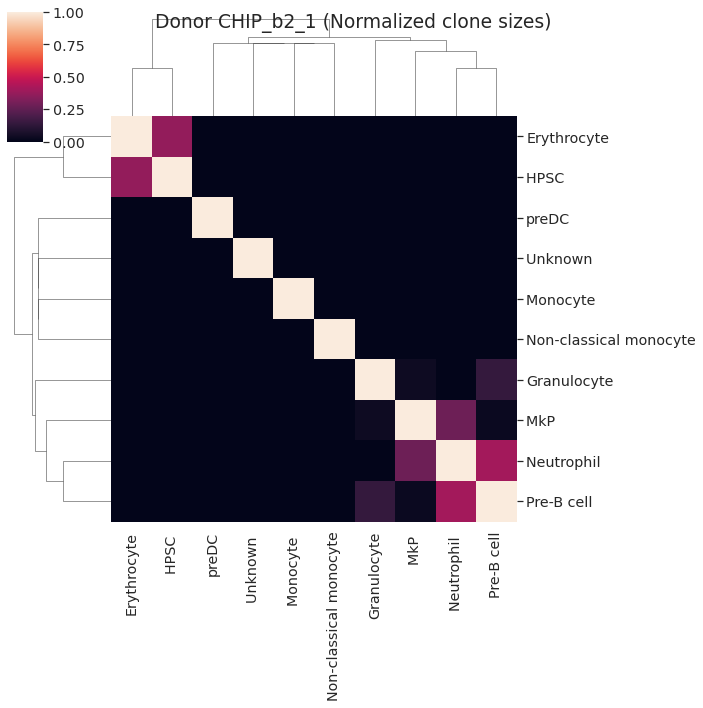

In [18]:
filt_clone_counts = keep_top_clones(clone_counts, min_cell=min_cell)
clone_norm = filt_clone_counts.copy()

clone_norm["ncells"] = np.log2(1+clone_norm["ncells"])
clone_sums = filt_clone_counts.groupby(["donor", "name"]).sum()["ncells"]
clone_sums


clone_norm["ncells"] = clone_norm.apply(lambda x: x["ncells"]/clone_sums.loc[(x["donor"], x["name"])] , axis=1)
clone_norm = clone_norm[~(clone_norm["name"]=="None")]
clone_norm_combined = clone_norm.groupby(["name", "donor", "nuclear_clusters"]).sum()["ncells"].reset_index().sort_values("ncells", ascending=False).set_index("name")
clone_norm_combined



clone_norm_df = pd.concat((clone_norm_combined, clone_norm_combined.apply(get_clone_count, axis=1, args=(clone_norm,))),axis=1).fillna(0)
#norm_corr_df = clone_norm_df.drop(["ncells", "donor"],axis=1).corr(method="spearman")

norm_corr_df, norm_pval_df = get_corr(clone_norm_df, corr_method)
norm_corr_df.to_csv(join(outdir, "normClones_correlation.csv"))

sns.clustermap(norm_corr_df.loc[(~norm_corr_df.isnull().all(axis=1)),(~norm_corr_df.isnull().all())], vmin=0, vmax=1)
plt.suptitle("Fate correlation (all donors, normalized within each clone)")
hs(join(outdir, "normClones_allDonors.png"), to_pdf=True)



plot_repr_corr(clone_norm_df, norm_corr_df, label="norm ncells", out_f=join(outdir, "normClones_fateCorr_scatter_allDonors.png"))

plot_repr_corr(clone_norm_df, norm_corr_df, label="norm ncells", top=True, 
               out_f=join(outdir, "top_normClones_fateCorr_scatter_allDonors.png"))

for don, val in clone_norm_df.groupby("donor"):
    #corr_df = val.drop(["ncells", "donor"],axis=1).corr(method="spearman")
    corr_df, pval_df = get_corr(val, corr_method)
    sns.clustermap(corr_df.loc[(~corr_df.isnull().all(axis=1)),(~corr_df.isnull().all())].fillna(0), vmin=0, vmax=1)
    plt.suptitle(f"Donor {don} (Normalized clone sizes)")


---

## e) Separate clones into conditions and run for combined and separate
(no min_cell)

In [19]:
cl_cond_counts_df = se_cells_meta.groupby(["nuclear_clusters", "condition", "donor", "name"]).size().reset_index().rename({0:"ncells"}, axis=1)
cl_cond_counts_df
wide_cl_cond_counts_df = cl_cond_counts_df.reset_index().pivot(columns="nuclear_clusters", index=["condition", "donor",
                                                                                       "name"], values="ncells").fillna(0)
wide_cl_cond_counts_df

nuclear_clusters                  Erythrocyte  Granulocyte  HPSC   MkP   \
condition donor     name                                                  
Input     CHIP_a1_0 CHIP_a1_0_0           0.0         21.0   26.0  37.0   
                    CHIP_a1_0_1           0.0         16.0   13.0  17.0   
                    CHIP_a1_0_10          0.0          4.0    4.0   0.0   
                    CHIP_a1_0_11          0.0          1.0    0.0   4.0   
                    CHIP_a1_0_12          0.0          0.0    0.0   2.0   
...                                       ...          ...    ...   ...   
          CHIP_b2_1 CHIP_b2_1_5           8.0          2.0   54.0   2.0   
                    CHIP_b2_1_6           9.0          4.0   56.0   0.0   
                    CHIP_b2_1_7           9.0          0.0   56.0   3.0   
                    CHIP_b2_1_8          14.0          3.0   50.0   2.0   
                    CHIP_b2_1_9          11.0          3.0   41.0   0.0   

nuclear_clusters                  Monocyte   Neutrophil   \
condition donor     name                                   
Input     CHIP_a1_0 CHIP_a1_0_0        61.0         54.0   
                    CHIP_a1_0_1        27.0         22.0   
                    CHIP_a1_0_10        7.0          3.0   
                    CHIP_a1_0_11        1.0          3.0   
                    CHIP_a1_0_12        0.0          3.0   
...                                     ...          ...   
          CHIP_b2_1 CHIP_b2_1_5         2.0          0.0   
                    CHIP_b2_1_6         2.0          1.0   
                    CHIP_b2_1_7         1.0          2.0   
                    CHIP_b2_1_8         1.0          1.0   
                    CHIP_b2_1_9         1.0          2.0   

nuclear_clusters                  Non-classical monocyte  Pre-B cell  \
condition donor     name                                               
Input     CHIP_a1_0 CHIP_a1_0_0                     12.0         0.0   
                    CHIP_a1_0_1                      9.0         0.0   
                    CHIP_a1_0_10                     0.0         0.0   
                    CHIP_a1_0_11                     1.0         0.0   
                    CHIP_a1_0_12                     1.0         0.0   
...                                                  ...         ...   
          CHIP_b2_1 CHIP_b2_1_5                      0.0         9.0   
                    CHIP_b2_1_6                      1.0         2.0   
                    CHIP_b2_1_7                      0.0         1.0   
                    CHIP_b2_1_8                      0.0         2.0   
                    CHIP_b2_1_9                      0.0         6.0   

nuclear_clusters                  Unknown   preDC  
condition donor     name                           
Input     CHIP_a1_0 CHIP_a1_0_0        4.0    0.0  
                    CHIP_a1_0_1        4.0    2.0  
                    CHIP_a1_0_10       1.0    1.0  
                    CHIP_a1_0_11       0.0    0.0  
                    CHIP_a1_0_12       0.0    0.0  
...                                    ...    ...  
          CHIP_b2_1 CHIP_b2_1_5        1.0    2.0  
                    CHIP_b2_1_6        1.0    3.0  
                    CHIP_b2_1_7        0.0    4.0  
                    CHIP_b2_1_8        0.0    1.0  
                    CHIP_b2_1_9        1.0    1.0  

[176 rows x 10 columns]

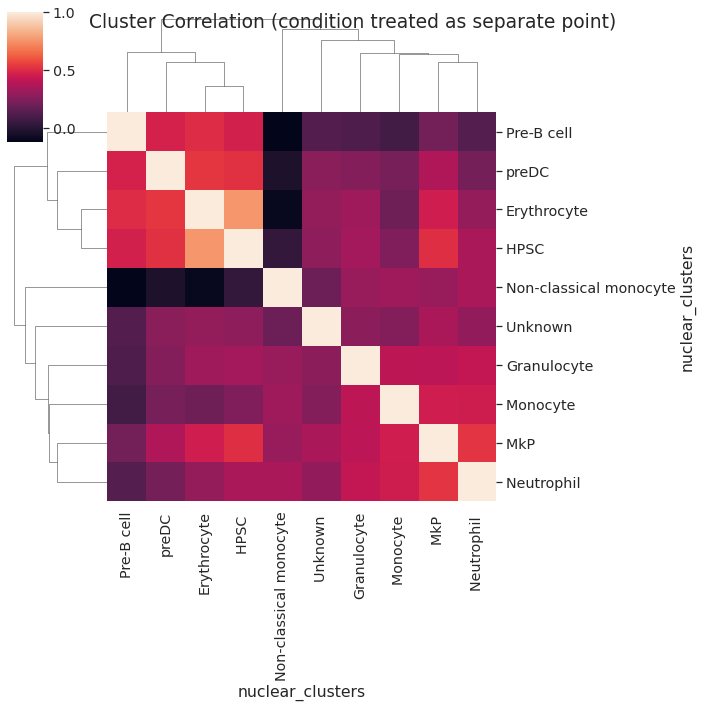

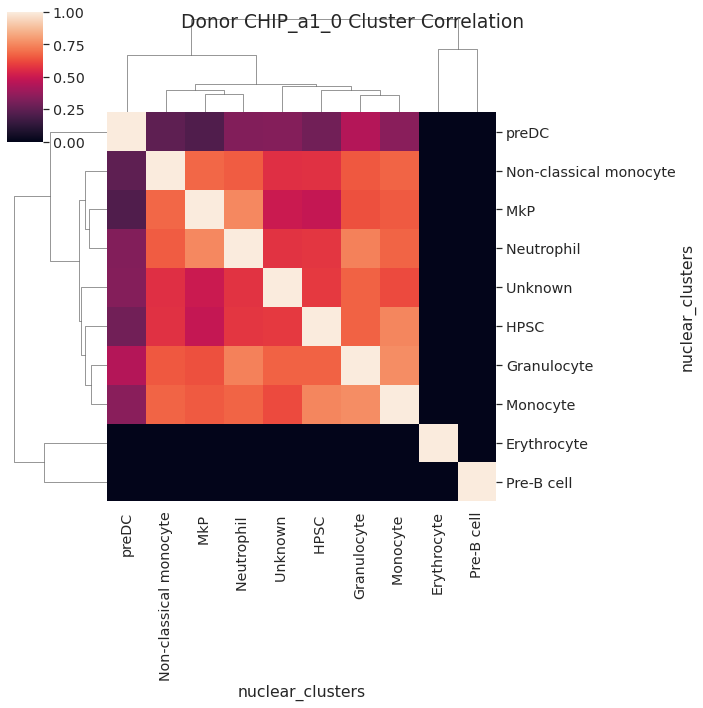

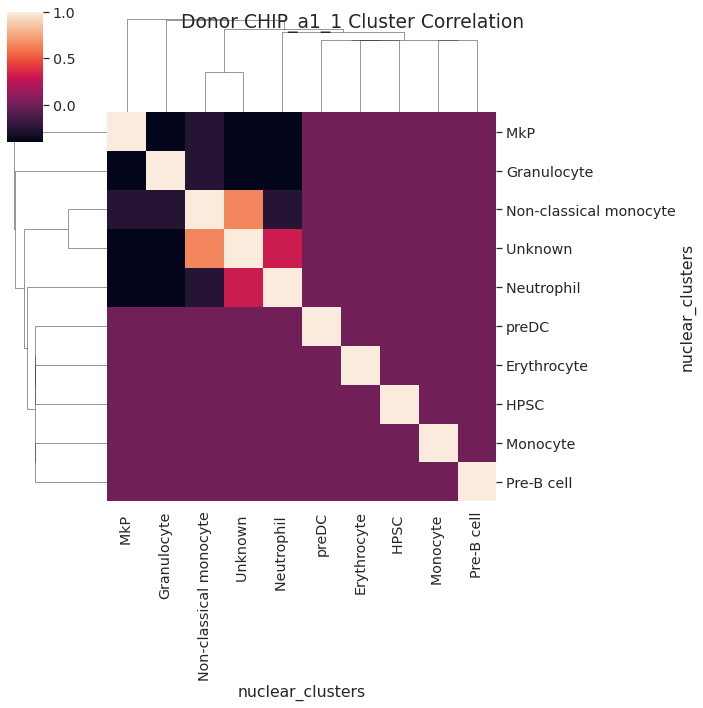

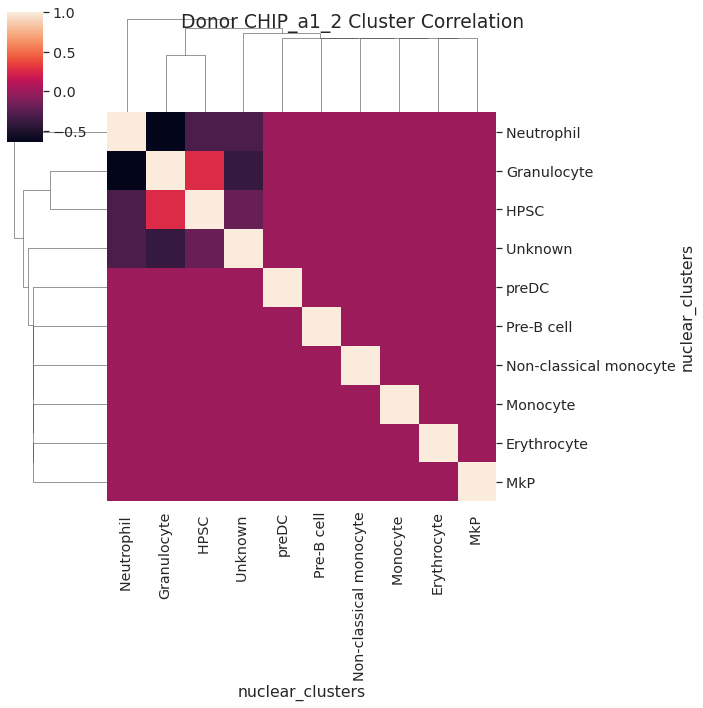

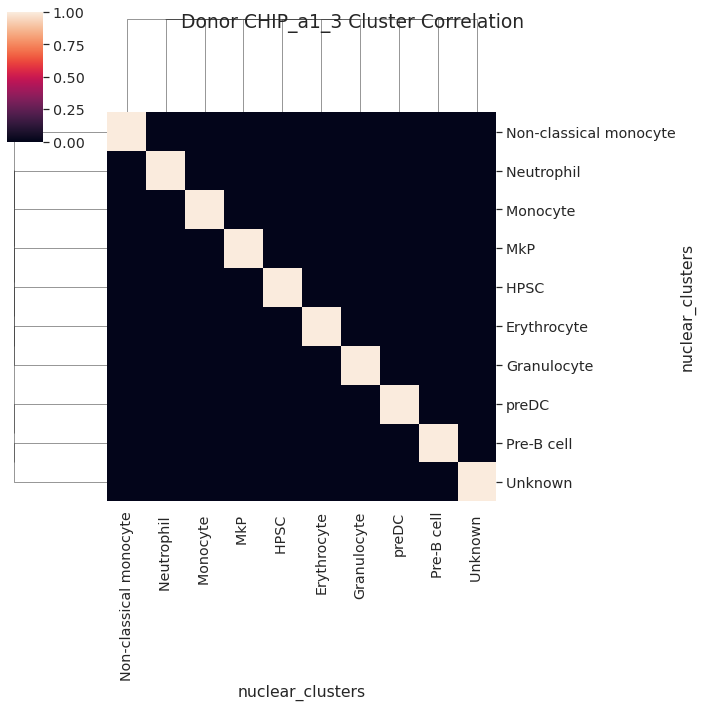

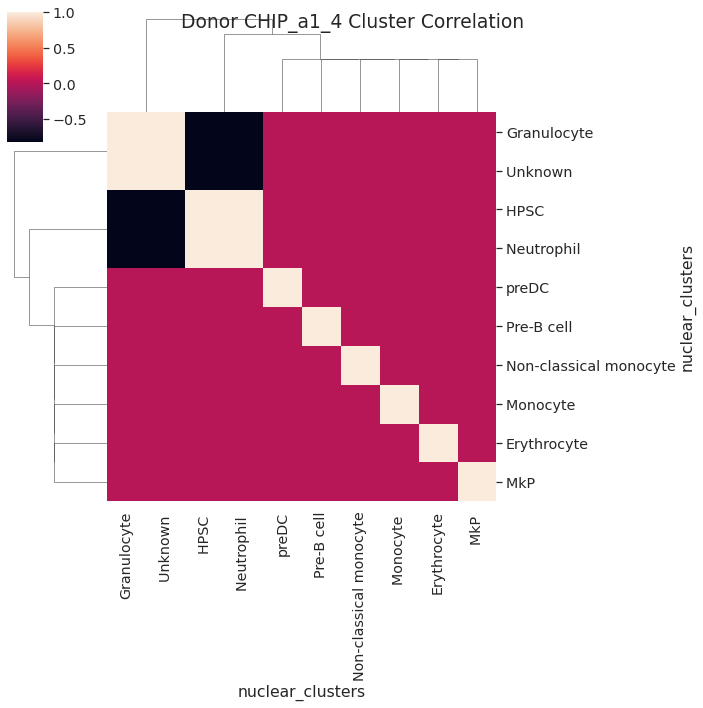

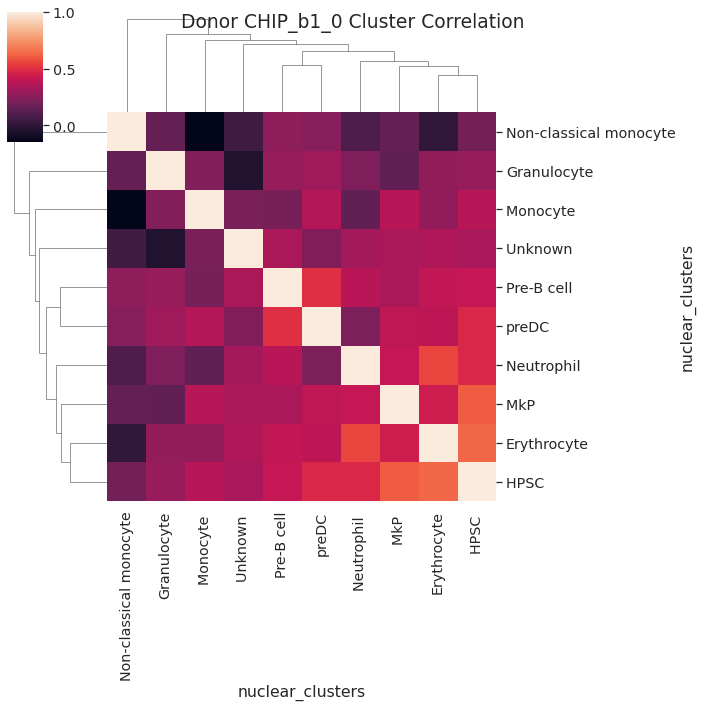

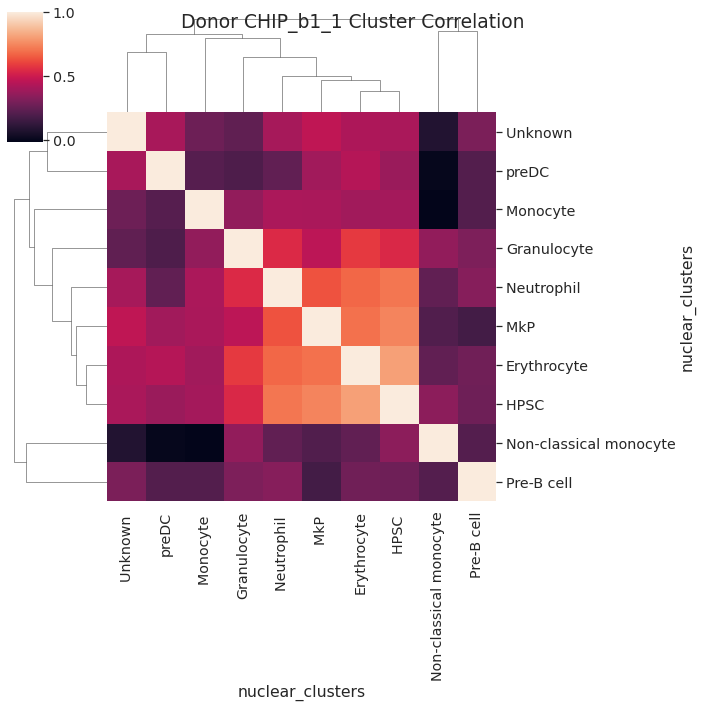

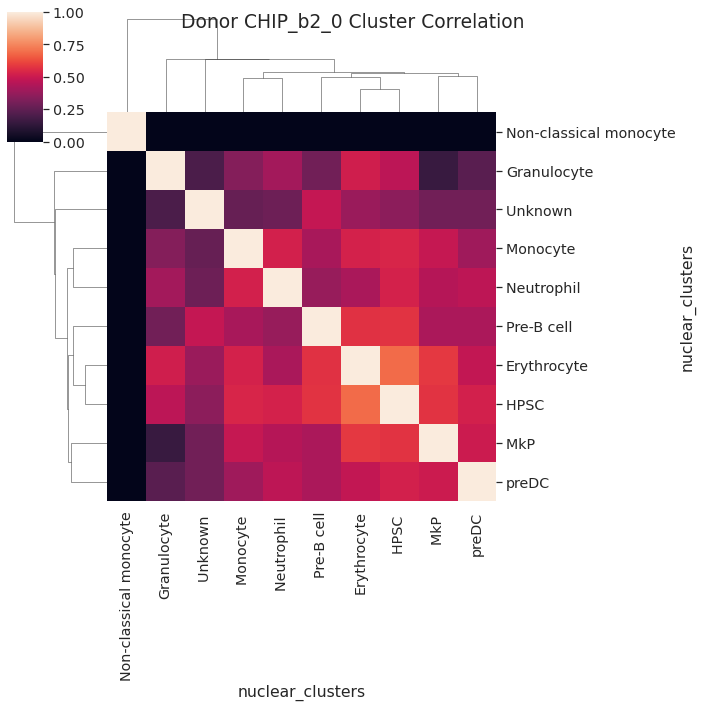

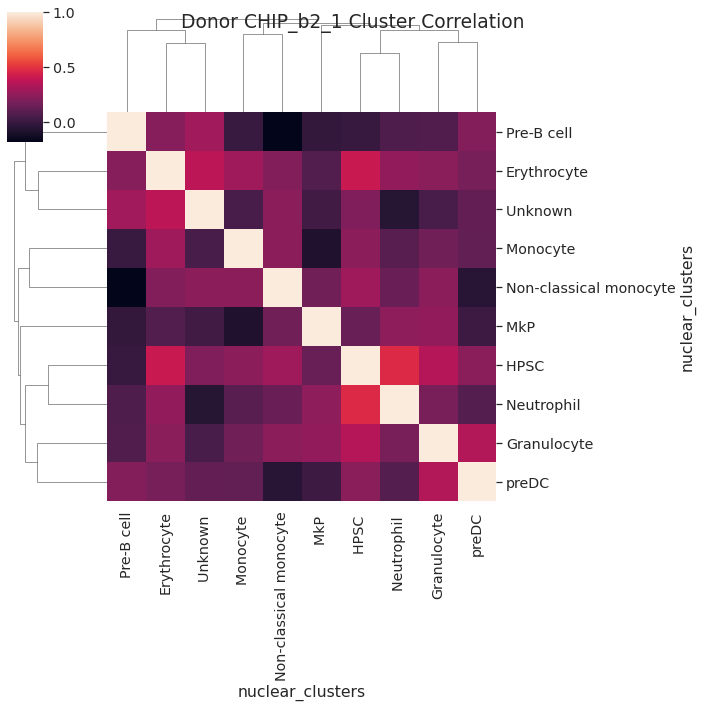

In [20]:
log2_clone_counts_df = wide_cl_cond_counts_df.copy()
log2_clone_counts_df[hue_order] = np.log2(1+log2_clone_counts_df[hue_order])

#cond_corr_df = log2_clone_counts_df.corr(method="spearman")
cond_corr_df, cond_pval_df = get_corr(log2_clone_counts_df, corr_method)


cond_corr_df
sns.clustermap(cond_corr_df)
hs(join(outdir, "fateCorr_sepCond_allDonors.png"), to_pdf=True)

plt.suptitle("Cluster Correlation (condition treated as separate point)")
for don, val in log2_clone_counts_df.reset_index().groupby("donor"):
    corr_df, pval_df = get_corr(val, corr_method=corr_method)

    sns.clustermap(corr_df)
    plt.suptitle(f"Donor {don} Cluster Correlation")

## Get top, middle, and bottom 2 correlations - Conditions treated separately

[nuclear_clusters                         0         1  \
 condition donor     name                               
 Input     CHIP_a1_0 CHIP_a1_0_0   0.000000  4.754888   
                     CHIP_a1_0_1   0.000000  3.807355   
                     CHIP_a1_0_10  0.000000  2.321928   
                     CHIP_a1_0_11  0.000000  0.000000   
                     CHIP_a1_0_12  0.000000  0.000000   
 ...                                    ...       ...   
           CHIP_b2_1 CHIP_b2_1_5   3.169925  5.781360   
                     CHIP_b2_1_6   3.321928  5.832890   
                     CHIP_b2_1_7   3.321928  5.832890   
                     CHIP_b2_1_8   3.906891  5.672425   
                     CHIP_b2_1_9   3.584963  5.392317   
 
 nuclear_clusters                                                    comp  
 condition donor     name                                                  
 Input     CHIP_a1_0 CHIP_a1_0_0   Erythrocyte__HPSC  (kendall_b r=0.758)  
                     CHIP_a1_

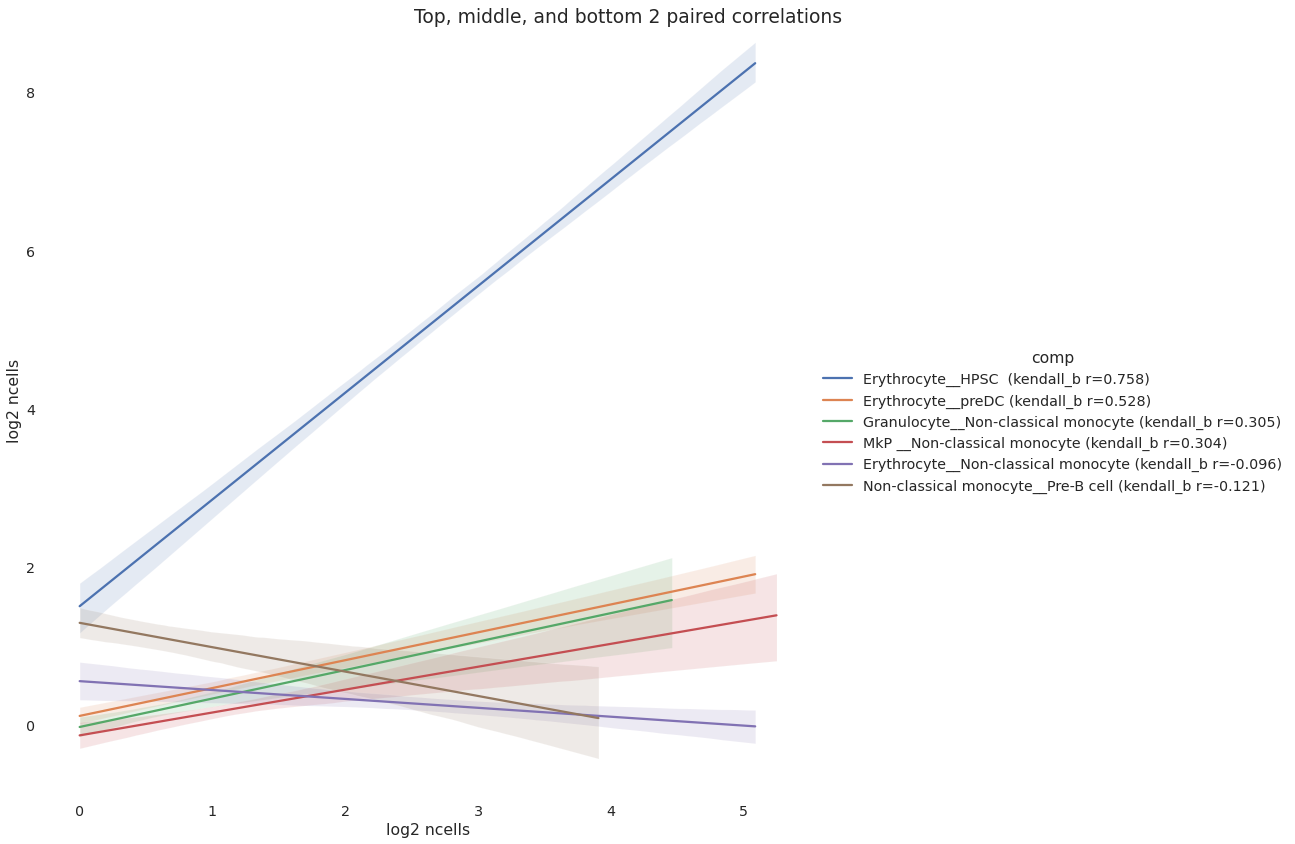

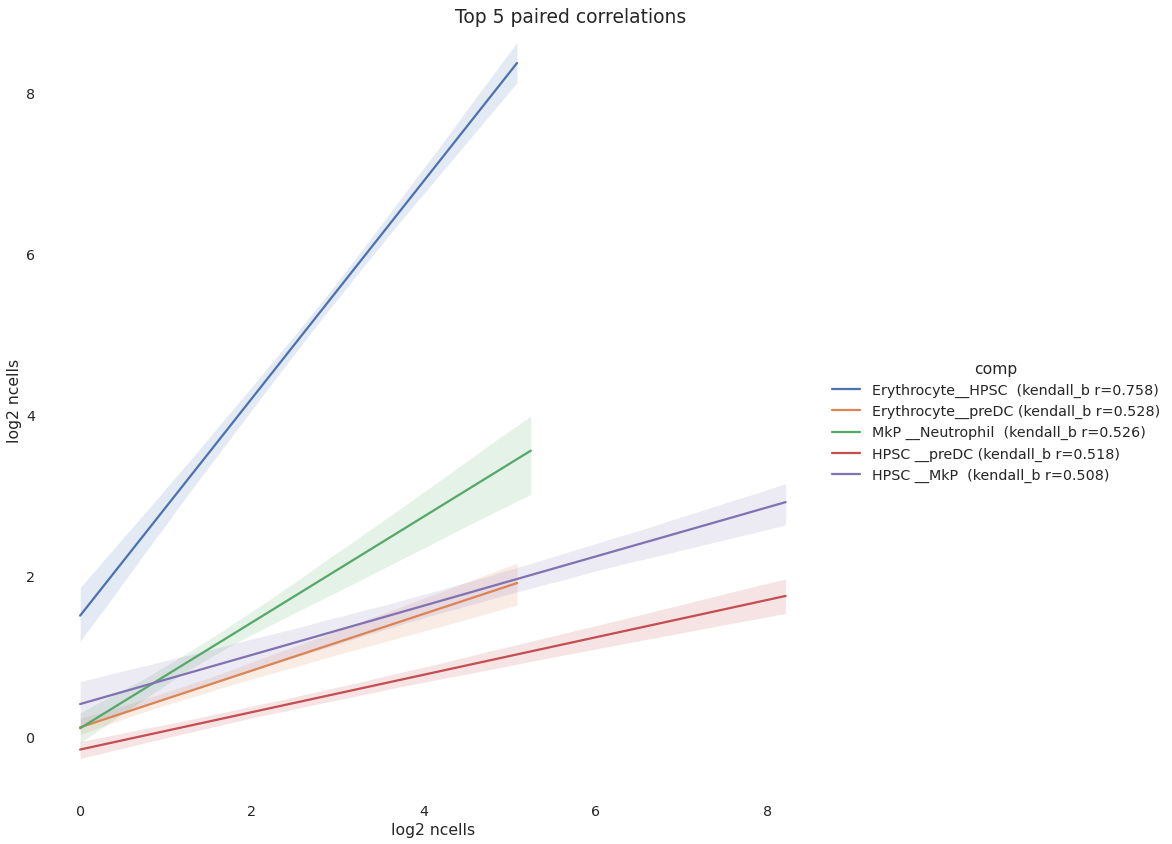

In [21]:
plot_repr_corr(log2_clone_counts_df, cond_corr_df, label="log2 ncells", 
               out_f=join(outdir, "fateCorr_scatter_sepCond_allDonors.png"))

plot_repr_corr(log2_clone_counts_df, cond_corr_df, label="log2 ncells", top=True,
               out_f=join(outdir, "top_fateCorr_scatter_sepCond_allDonors.png"))



## Pairplot of clusters

In [22]:
#g = sns.pairplot(log2_clone_counts_df.reset_index().drop(["name","donor"], axis=1), hue="condition", height=4)

---

---

---

In [23]:
outdir

'/data/Mito_Trace/output/aggregate/CHIP_aggr/v04/data/clone_var_init/variants.prefilterMerge_impute_knnRes.30/aggregate/annotation/fate_corr/minC5_corr.Kendall.b_group_inputOnly/'